In [1]:
'''
Developed by Sumbit, Inc for AI Trade Signals project. Please refrain from sharing the data/ideas/code used here with others.
Please be careful especially with academics. They have used our ideas to publish papers and books in the past.
This code and data are given to you for your learning only. It belongs to Sumbit Inc., Feel free to use it to enhance your skills in machine learning.
'''

'\nDeveloped by Sumbit, Inc for AI Trade Signals project. Please refrain from sharing the data/ideas/code used here with others.\nPlease be careful especially with academics. They have used our ideas to publish papers and books in the past.\nThis code and data are given to you for your learning only. It belongs to Sumbit Inc., Feel free to use it to enhance your skills in machine learning.\n'

In [2]:
'''
If you are running locally then 
1. reboot your local machine
2. create an environment called 'colab' using anaconda prompt
if you have a gpu
conda create -n colab python tensorflow-gpu 
if not 
conda create -n colab python tensorflow
3. to install jupyter notebook
conda install jupyter notebook
4. to go to the 'colab' environment
activate colab
5. change file path to locate this notebook and then type 'jupyter notebook'

If you use colab
1. save the data file in your google drive
2. goto colab and start running the code
'''

"\nIf you are running locally then \n1. reboot your local machine\n2. create an environment called 'colab' using anaconda prompt\nif you have a gpu\nconda create -n colab python tensorflow-gpu \nif not \nconda create -n colab python tensorflow\n3. to install jupyter notebook\nconda install jupyter notebook\n4. to go to the 'colab' environment\nactivate colab\n5. change file path to locate this notebook and then type 'jupyter notebook'\n\nIf you use colab\n1. save the data file in your google drive\n2. goto colab and start running the code\n"

In [3]:
#install prominent libraries with specific versions. Change versions to the output of block 4
#!pip install tensorflow==1.15.0
#!pip install keras==2.2.4-tf
#!pip install pandas== 0.25.1
#!pip install sklearn==0.23.1
#!pip install matplotlib==3.2.1
#!pip install hyperas
#!pip install hyperopt
#!pip install yfinance
#!pip install pandas_market_calendars

In [4]:
from __future__ import print_function                                                                                                                                                                                                                                                                                                                              # from tensorflow.contrib.rnn import *import pandas as pd
import numpy as np
import os
import random
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, CuDNNLSTM, CuDNNGRU, Input, Activation, Flatten, BatchNormalization, Reshape,Concatenate,Bidirectional, TimeDistributed
from keras.callbacks import ModelCheckpoint, TensorBoard, History
from keras.models import Model, load_model
from keras.layers.advanced_activations import LeakyReLU
from keras import regularizers
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, KFold, train_test_split
from keras.wrappers.scikit_learn import KerasClassifier
import matplotlib.pyplot as plt
from matplotlib import style
from keras.optimizers import SGD, RMSprop, Adam, Adadelta
from keras.utils import np_utils
from sklearn.preprocessing import*
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout
from keras.layers import BatchNormalization
from keras.optimizers import SGD, RMSprop, Adam, Adadelta
from keras.utils import np_utils, to_categorical
from keras.callbacks import ModelCheckpoint, TensorBoard, History, ReduceLROnPlateau 
import pandas as pd
from keras import regularizers
from keras.callbacks import ModelCheckpoint
from collections import Counter
import operator
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
import itertools
import hyperas
import hyperopt
from hyperas.distributions import choice, uniform
from hyperas import optim
from hyperopt import Trials, STATUS_OK, tpe, rand
from keras.layers import Conv1D, MaxPooling1D, ZeroPadding1D
import pandas_market_calendars as mcal 
import datetime 
from datetime import timedelta  
import yfinance as yf
import glob 
import pickle
import gc
from IPython.display import clear_output

Using TensorFlow backend.


In [5]:
#Get library versions
print("tensorflow.__version__ = ", tf.__version__)
#import tensorflow.python.keras
#print("keras.__version__ = ", tensorflow.python.keras.__version__)
import sklearn 
print("sklearn.__version__ = ", sklearn.__version__)
print("numpy.__version__ = ", np.__version__)
print("pandas.__version__ = ", pd.__version__)
import matplotlib
print("matplotlib.__version__ = ", matplotlib.__version__)
now = datetime.datetime.now()
today = now.strftime("%Y-%m-%d")
print ("Last run date : ", today)

tensorflow.__version__ =  1.15.0
sklearn.__version__ =  0.23.1
numpy.__version__ =  1.19.1
pandas.__version__ =  1.1.0
matplotlib.__version__ =  3.2.2
Last run date :  2020-08-14


In [6]:
'''
*****************************************************
please make sure the model_name is the same as the notebook name
*****************************************************
'''
model_name = '3.2P_CuDNNLSTM' # For hyperas, it is the notebook name (make sure the notebook resides in google drive if using colab)
max_evals = 20 # number of hyperas evaluations for finding hyperparameters. More choices will require to higher evaluations
early_stopping_count= 500 # stop training run if there is no improvement in accuracy after the choosen epoch count
training_epochs=2000 # Note: hyperas epochs are different from training epochs
training_verbose = 2 #choice 0, 1, 2 or False
checkpointer_verbose = 2 #choice 0, 1, 2 or False
call_reduce_verbose = 1 #choice 0, 1, 2 or False

In [7]:
# change data parameters to improve accuracy
def data_params():
    """
    Function passes global data parameters to hyperas optim.minimize method.
    Please make ensure __pycache__ in your folder and and temp_model.py files are deleted 
    manually if you are making changes to these parameters
    """
    
    batch_size= 512  # batch_size for training and evaluation
    time_steps = 28   # Number of time steps to create in the dataset
    rm_window =100     # Number of rolling mean columns for choosen ticker price
    hyperas_epochs = 20 # number of epochs for each trials during hypears evaluation
    forecast_period = 7 # can be 1 to 7 in a 7day model dataset(given)
    
    '''
    ***********************************************************************************
    check to see if using 'RobustScaler','Normalizer', 'MinMaxScaler', 'MaxAbsScaler', 
    'PowerTransformer', 'QuantileTransformer' instead of 'StandardScaler' improves accuracy
    ***********************************************************************************
    '''
    x_scaler=StandardScaler()# change the pre-processing method to improve accuracy
    y_scaler=StandardScaler()
    
    return batch_size, time_steps, rm_window, hyperas_epochs, forecast_period, x_scaler, y_scaler

In [8]:
'''
***************************************************************************************************
Please choose 'True' or 'False' parameter for search, train and starting epoch one 
*****************************************************************************************************
'''

best_model_search = True # 'True' to search for best model, 'False' to use already saved existing best model
perform_training = True# 'True' to  train, 'False' to not to train after best_model search
starting_epoch_one = True # 'True' to train from scratch(epoch 1) , 'False' to load the last checkpoint weights of previous training run
evaluate_all_folds = True # evaluate the trained model for all the folds

In [9]:
def data_split():  
    kfold = False # 'True' to implement kfold, 'False' to use train_test_split
    train_size = 0.85  # use train_test_split between (0.7 to 0.9),make sure test is atleast of one batch_size
    shuffle = True # 'True' to shuffle
    split = 10 # number of splits in kfold
    fold_number = 8 # (the choosen fold_number of the split becomes test data, rest becomes train data)
    random_state= 54 # for random seed
    return kfold, train_size, shuffle, split, fold_number,random_state

In [10]:
if os.path.exists('best_model/'+model_name+'.h5'):
    print('Best model exists but you can still search for a better model')
    best_model_input_shape = load_model('best_model/'+model_name+'.h5').input_shape
        
else:
    print('Best model doesnt exist, changing best_model variable to True')
    best_model_search= True
    

if best_model_search and perform_training:
    print('you have choosen to search for best model and then train')
elif best_model_search and not perform_training:
    print('you have choosen to search for best model only')
elif not best_model_search and perform_training:
    print('you have choosen to train using already saved best model')
    print('For training use best model batch_size:', best_model_input_shape[0])
    print('For training use best model time steps:', best_model_input_shape[1])
    print('For training use best model features:', best_model_input_shape[2])
elif not best_model_search and not perform_training:
     print('you have choosen to not to search or train. Therefore the model will not run')  

if os.path.exists('train_model/checkpoint/'+model_name+'.ckpt'):
    print('check point exists')
    if os.path.exists('train_metrics/'+model_name+'.csv'):
        train_metrics = pd.read_csv('train_metrics/'+model_name+'.csv', index_col=0)
        print('\n','Results of last run checkpoint:')
        print(train_metrics.tail(1))       
else:
    print("check point doesn't exist, starting training from the epoch 1")
    starting_epoch_one = True 

Best model exists but you can still search for a better model
Instructions for updating:
If using Keras pass *_constraint arguments to layers.

you have choosen to search for best model and then train
check point exists


In [11]:
#random seed to generate reproduceable results
_, _, _, _, _, random_state = data_split()
from numpy.random import seed
seed(random_state)
try:
    tf.compat.v1.set_random_seed(random_state)
except:
    from tensorflow import set_random_seed
    set_random_seed(random_state)
random.seed(random_state)
os.environ['PYTHONHASHSEED']=str(1)
os.environ['TF_KERAS'] = '1'

In [12]:
# create these folders if they do not exist
def build_path(dirName):
    try:
        os.makedirs(dirName)    
        print("Directory " , dirName ,  " created ")
    except:
        print("Directory " , dirName ,  " already exists")  

In [13]:
# to check if GPU is getting used locally.....you need to see CPU as well as GPU in the output
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 6158193534031571540
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 7125503181
locality {
  bus_id: 1
  links {
  }
}
incarnation: 8646262434642142101
physical_device_desc: "device: 0, name: GeForce GTX 1070, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


In [14]:
def feature_selection():
    '''
    Function reads the dataset and prepares inputs and labels
    '''
    ticker = '^GSPC'  # ticker to classify as buy or sell
    #features
    stocks = ['A', 'AAL', 'AAP', 'AAPL', 'ABBV', 'ABC', 'ABMD', 'ABT', 'ACN', 'ADBE', 'ADI', 'ADM', 'ADP', 'ADS', 'ADSK', 'AEE', 'AEP', 'AES', 'AFL', 'AGN', 'AIG', 'AIV', 'AIZ', 'AJG', 'AKAM', 'ALB', 'ALGN', 'ALK', 'ALL', 'ALLE', 'ALXN', 'AMAT', 'AMCR', 'AMD', 'AME', 'AMGN', 'AMP', 'AMT', 'AMZN', 'ANET', 'ANSS', 'ANTM', 'AON', 'AOS', 'APA', 'APD', 'APH', 'APTV', 'ARE', 'ARNC', 'ATO', 'ATVI', 'AVB', 'AVGO', 'AVY', 'AWK', 'AXP', 'AZO', 'BA', 'BAC', 'BAX', 'BBY', 'BDX', 'BEN', 'BF-B', 'BIIB', 'BK', 'BKNG', 'BKR', 'BLK', 'BLL', 'BMY', 'BR', 'BRK-B', 'BSX', 'BWA', 'BXP', 'C', 'CAG', 'CAH', 'CAT', 'CB', 'CBOE', 'CBRE', 'CCI', 'CCL', 'CDNS', 'CDW', 'CE', 'CERN', 'CF', 'CFG', 'CHD', 'CHRW', 'CHTR', 'CI', 'CINF', 'CL', 'CLX', 'CMA', 'CMCSA', 'CME', 'CMG', 'CMI', 'CMS', 'CNC', 'CNP', 'COF', 'COG', 'COO', 'COP', 'COST', 'COTY', 'CPB', 'CPRI', 'CPRT', 'CRM', 'CSCO', 'CSX', 'CTAS', 'CTL', 'CTSH', 'CTVA', 'CTXS', 'CVS', 'CVX', 'CXO', 'D', 'DAL', 'DD', 'DE', 'DFS', 'DG', 'DGX', 'DHI', 'DHR', 'DIA', 'DIS', 'DISCA', 'DISCK', 'DISH', 'DLR', 'DLTR', 'DOV', 'DOW', 'DRE', 'DRI', 'DTE', 'DUK', 'DVA', 'DVN', 'DX-Y.NYB', 'DXC', 'EA', 'EBAY', 'ECL', 'ED', 'EFX', 'EIX', 'EL', 'EMN', 'EMR', 'EOG', 'EQIX', 'EQR', 'ES', 'ESS', 'ETFC', 'ETN', 'ETR', 'EVRG', 'EW', 'EXC', 'EXPD', 'EXPE', 'EXR', 'F', 'FANG', 'FAST', 'FB', 'FBHS', 'FCX', 'FDX', 'FE', 'FFIV', 'FIS', 'FISV', 'FITB', 'FLIR', 'FLS', 'FLT', 'FMC', 'FOX', 'FOXA', 'FRC', 'FRT', 'FTI', 'FTNT', 'FTV', 'GD', 'GE', 'GILD', 'GIS', 'GL', 'GLW', 'GM', 'GOOG', 'GPC', 'GPN', 'GPS', 'GRMN', 'GS', 'GWW', 'HAL', 'HAS', 'HBAN', 'HBI', 'HCA', 'HD', 'HES', 'HFC', 'HIG', 'HII', 'HLT', 'HOG', 'HOLX', 'HON', 'HP', 'HPE', 'HPQ', 'HRB', 'HRL', 'HSIC', 'HST', 'HSY', 'HUM', 'IBM', 'ICE', 'IDXX', 'IEX', 'IFF', 'ILMN', 'INCY', 'INFO', 'INTC', 'INTU', 'IP', 'IPG', 'IPGP', 'IQV', 'IR', 'IRM', 'ISRG', 'IT', 'ITW', 'IVZ', 'J', 'JBHT', 'JCI', 'JKHY', 'JNJ', 'JNPR', 'JPM', 'JWN', 'K', 'KEY', 'KEYS', 'KHC', 'KIM', 'KLAC', 'KMB', 'KMI', 'KMX', 'KO', 'KR', 'KSS', 'KSU', 'L', 'LB', 'LDOS', 'LEG', 'LEN', 'LH', 'LHX', 'LIN', 'LKQ', 'LLY', 'LMT', 'LNC', 'LNT', 'LOW', 'LRCX', 'LUV', 'LVS', 'LW', 'LYB', 'LYV', 'M', 'MA', 'MAA', 'MAR', 'MAS', 'MCD', 'MCHP', 'MCK', 'MCO', 'MDLZ', 'MDT', 'MET', 'MGM', 'MHK', 'MKC', 'MKTX', 'MLM', 'MMC', 'MMM', 'MNST', 'MO', 'MOS', 'MPC', 'MRK', 'MRO', 'MS', 'MSCI', 'MSFT', 'MSI', 'MTB', 'MTD', 'MU', 'MXIM', 'MYL', 'NBL', 'NCLH', 'NDAQ', 'NEE', 'NEM', 'NFLX', 'NI', 'NKE', 'NLOK', 'NLSN', 'NOC', 'NOV', 'NOW', 'NRG', 'NSC', 'NTAP', 'NTRS', 'NUE', 'NVDA', 'NVR', 'NWL', 'NWS', 'NWSA', 'O', 'ODFL', 'OKE', 'OMC', 'ORCL', 'ORLY', 'OXY', 'PAYX', 'PBCT', 'PCAR', 'PEAK', 'PEG', 'PEP', 'PFE', 'PFG', 'PG', 'PGR', 'PH', 'PHM', 'PKG', 'PKI', 'PLD', 'PM', 'PNC', 'PNR', 'PNW', 'PPG', 'PPL', 'PRGO', 'PRU', 'PSA', 'PSX', 'PVH', 'PWR', 'PXD', 'PYPL', 'QCOM', 'QRVO', 'RCL', 'RE', 'REG', 'REGN', 'RF', 'RHI', 'RJF', 'RL', 'RMD', 'ROK', 'ROL', 'ROP', 'ROST', 'RSG', 'RTN', 'SBAC', 'SBUX', 'SCHW', 'SEE', 'SHW', 'SIVB', 'SJM', 'SLB', 'SLG', 'SNA', 'SNPS', 'SO', 'SPG', 'SPGI', 'SPY', 'SRE', 'STE', 'STT', 'STX', 'STZ', 'SWK', 'SWKS', 'SYF', 'SYK', 'SYY', 'T', 'TAP', 'TDG', 'TEL', 'TFC', 'TFX', 'TGT', 'TIF', 'TJX', 'TMO', 'TMUS', 'TPR', 'TROW', 'TRV', 'TSCO', 'TSN', 'TTWO', 'TWTR', 'TXN', 'TXT', 'UA', 'UAA', 'UAL', 'UDR', 'UHS', 'ULTA', 'UNH', 'UNM', 'UNP', 'UPS', 'URI', 'USB', 'UTX', 'V', 'VAR', 'VFC', 'VIAC', 'VLO', 'VMC', 'VNO', 'VRSK', 'VRSN', 'VRTX', 'VTR', 'VZ', 'WAB', 'WAT', 'WBA', 'WCG', 'WDC', 'WEC', 'WELL', 'WFC', 'WHR', 'WLTW', 'WM', 'WMB', 'WMT', 'WRB', 'WRK', 'WU', 'WY', 'WYNN', 'XEC', 'XEL', 'XLB', 'XLE', 'XLF', 'XLI', 'XLK', 'XLNX', 'XLP', 'XLU', 'XLV', 'XLY', 'XOM', 'XRAY', 'XRT', 'XRX', 'XYL', 'YUM', 'ZBH', 'ZBRA', 'ZION', 'ZTS', '^GSPC', '^IXIC', '^NDX', '^SOX', '^TNX', '^VIX', '^VVIX', '^VXN', '^VXO', '^VXV']
    short_interest = ['Trading Volume']
    nytimes = ['neg', 'neu', 'pos']
    economic = ['Dividend', 'Earnings', 'CPI', 'Long Interest Rate', 'Real Price', 'Real Dividend', 'Real Earnings', 'Cyclically Adjusted PE Ratio', 'ECRI USLEADING LEVEL', 'ECRI USLEADING GROWTH', 'ECRI USLAGGING LEVEL', 'ECRI USLAGGING GROWTH', 'ECRI_USCOIN LEVEL', 'ECRI_USCOIN GROWTH', 'University of Michigan Consumer Survey, Index of Consumer Sentiment', 'Bullish', 'Neutral', 'Bearish', 'Bullish 8-Week Mov Avg', 'Bull-Bear Spread', 'Bullish Average', 'Bullish Average + St. Dev', 'Bullish Average - St. Dev', 'Stock Market Confidence Indices - United States One Year Index Data - Individual', 'Stock Market Confidence Indices - United States One Year Index Data - Institutional', 'Stock Market Confidence Indices - United States Buy on Dips Confidence Index Data - Individual', 'Stock Market Confidence Indices - United States Buy on Dips Confidence Index Data - Institutional', 'Stock Market Confidence Indices - United States Crash Confidence Index Data - Individual', 'Stock Market Confidence Indices - United States Crash Confidence Index Data - Institutional', 'Stock Market Confidence Indices - United States Valuation Index Data - Individual', 'Stock Market Confidence Indices - United States Valuation Index Data - Institutional', 'Zillow Home Value Index (Metro): Zillow Rental Index - All Homes - United States', 'Zillow Home Value Index (Metro): Turnover - All Homes - United States', 'Zillow Home Value Index (Metro): Price To Rent Ratio - All Homes - United States', 'Zillow Home Value Index (Metro): Median Listing Price - All Homes - United States', 'Zillow Home Value Index (Metro):  Home Sold As Foreclosure - Ratio - All Homes - United States', 'Historical Housing Market Data - Real Home Price Index', 'Cost Index', 'U.S. Population (Millions)', 'Long Rate', 'Historical Housing Market Data - Nominal Home Price Index', 'Historical Housing Market Data - Consumer Price Index (Quarterly)', '30-Year Conventional Mortgage Rate', 'House Price Index - US National', '15-Year Fix Rate', '15-Year Fix Rate Fees & Points', '5-Year Adjustable Rate', '5-Year Adjustable Rate Fees & Points', '1-Year Adjustable Rate', '1-Year Adjustable Rate Fees & Points', '30-Year Fixed Rate Mortgage Average in the United States', 'Federal Funds Rate', '90 day T Bill Rate', 'One Year Maturity Treasury Yield', 'Ten Year Maturity Treasury Yield', 'Freddie Mac Commitment Fixed Rate Mortgages', 'Freddie Mac Commitment ARMs', 'Prime Rate', 'Total Housing Starts', 'Single Family Housing Starts', 'Multi-Family Housing Starts', 'New Single-Family Sales', 'Existing Single-Family Home Sales', '1-Year CD: National Rate of Banks', '5-Year CD: National Rate of Banks', 'Interest Checking Accounts: National Rate of Banks', 'Money Market Accounts: National Rate of Banks', '1-Month AA Financial Commercial Paper Rate', '3-Month AA Financial Commercial Paper Rate', '1-Month AA Nonfinancial Commercial Paper Rate', '3-Month AA Nonfinancial Commercial Paper Rate', 'Effective Federal Funds Rate', '10-Year Treasury Inflation-Indexed Security, Constant Maturity', '20-Year Treasury Inflation-Indexed Security, Constant Maturity', '30-Year Treasury Inflation-Indexed Security, Constant Maturity', '5-Year Treasury Inflation-Indexed Security, Constant Maturity', '7-Year Treasury Inflation-Indexed Security, Constant Maturity', '10-Year Treasury Constant Maturity Rate', '2-Year Treasury Constant Maturity Rate', '20-Year Treasury Constant Maturity Rate', '3-Year Treasury Constant Maturity Rate', '30-Year Treasury Constant Maturity Rate', '5-Year Treasury Constant Maturity Rate', '7-Year Treasury Constant Maturity Rate', 'Bank Prime Loan Rate', '1-Year Treasury Bill: Secondary Market Rate', '3-Month Treasury Bill: Secondary Market Rate', '4-Week Treasury Bill: Secondary Market Rate', '6-Month Treasury Bill: Secondary Market Rate', 'Overnight London Interbank Offered Rate (LIBOR), based on U.S. Dollar', 'Finance Rate on Personal Loans at Commercial Banks, 24 Month Loan', 'Commercial Bank Interest Rate on Credit Card Plans, All Accounts', 'RR3_TBILL_PGDP_2', 'RR3_TBILL_PGDP_3', 'RR3_TBILL_PGDP_4', 'RR3_TBILL_PGDP_5', 'RR2_TBILL_CCPI_2', 'RR2_TBILL_CCPI_3', 'RR2_TBILL_CCPI_4', 'RR2_TBILL_CCPI_5', 'Gross domestic product', 'Personal consumption expenditures', ':Goods', '::Durable goods', '::Nondurable goods', ':Services', 'Gross private domestic investment', 'Net exports of goods and services', 'Government consumption expenditures and gross investment', '::Gross domestic income (GDI)', '::Gross national product', '::Gross national income', '::Disposable personal income', 'Personal income', ':Compensation of employees', '::Wages and salaries', ':Population (midperiod; thousands)', '::Disposable personal income; current dollars', 'Services', ':Household consumption expenditures (for services)', '::Housing and utilities', '::Health care', '::Transportation services', '::Recreation services', '::Food services and accommodations', '::Financial services and insurance', '::Other services', 'Corporate profits with inventory valuation and capital consumption adjustments', 'Consumer Price Index - USA', 'United States Gross National Savings, % of GDP', 'United States GDP at Constant Prices, % change', 'Nominal Potential Gross Domestic Product', 'Industrial Production: Durable Goods: Other durable goods', 'FRED: Projection of General government net lending/borrowing for United States', 'FRED: Real Potential Gross Domestic Product', 'FRED: Real Gross Domestic Product', 'FRED: Gross Domestic Product', 'FRBP: GDPplus GDP Growth', 'Inflation YOY - USA', 'Consumer Price Index for All Urban Consumers: All Items', 'PRCCPI1', 'PRCCPI2', 'PRCCPI3', 'PRCCPI4', 'PRCCPI5', 'PRCCPI6', 'PRCCPI7', 'PRCCPI8', 'PRCCPI9', 'PRCCPI10', 'PRCCPI11', 'PRCCPI12', 'PRCCPI13', 'PRCCPI14', 'PRCCPI15', 'PRCCPI16', 'PRCCPI17', 'PRCCPI18', 'PRCCPI19', 'PRCCPI20', 'Mean CPI1', 'Mean CPI2', 'Mean CPI3', 'Mean CPI4', 'Mean CPI5', 'Mean CPI6', 'Mean CPIA', 'Mean CPIB', 'Mean CPIC', 'Median CPI1', 'Median CPI2', 'Median CPI3', 'Median CPI4', 'Median CPI5', 'Median CPI6', 'Median CPIA', 'Median CPIB', 'Median CPIC', 'CORECPI1', 'CORECPI2', 'CORECPI3', 'CORECPI4', 'CORECPI5', 'CORECPI6', 'CORECPIA', 'CORECPIB', 'CORECPIC', 'Median CORECPI1', 'Median CORECPI2', 'Median CORECPI3', 'Median CORECPI4', 'Median CORECPI5', 'Median CORECPI6', 'Median CORECPIA', 'Median CORECPIB', 'Median CORECPIC', 'Employment; Openings; All industries; Rate (Percent) - National', 'Employment; Gross Job Losses; All industries; Rate (Percent) - National', 'Employment - All employees, quarterly averages, seasonally adjusted, thousands; Total nonfarm industry', 'Employment - All employees, thousands; Total private industry', 'Employment - All employees, thousands; Total nonfarm industry', 'Hires for Total nonfarm in Total US Region', 'Layoffs and discharges for Total nonfarm in Total US Region', 'Total separations for Total nonfarm in Total US Region', 'Hires percent for Total private in Total US Region', 'Job openings for Total private in Total US Region', 'Job openings percent for Total private in Total US Region', 'Total separations for Total private in Total US Region', 'Hires for Construction in Total US Region', 'Total separations for Construction in Total US Region', 'Hires for Manufacturing in Total US Region', 'Hires for Government in Total US Region', 'Total separations for Government in Total US Region', 'US Forecast Unemployment Rate, % of Total Labor Force', 'ISM Manufacturing Employment Index', 'ISM Non-Manufacturing Employment Index', 'FRED Forecast Natural Rate of Unemployment (Short-Term)', 'FRED Forecast Natural Rate of Unemployment (Long-Term)', 'ADP_Total private', 'ADP_Goods producing', 'Service providing', 'ADP_Goods Producing Industries_1-19', 'ADP_Goods Producing Industries_20-49', 'ADP_Goods Producing Industries_1-49', 'ADP_Goods Producing Industries_50-499', 'ADP_Goods Producing Industries_500+', 'ADP_Goods Producing Industries_500-999', 'ADP_Goods Producing Industries_1,000+', 'ADP_Construction', 'ADP_Natural resources & mining', 'Manufacturing', 'ADP_Prof.l/business services', 'ADP_Professional services', 'ADP_Total Non-Farm Private_1-19', 'ADP_Total Non-Farm Private_20-49', 'ADP_Total Non-Farm Private_1-49', 'ADP_Total Non-Farm Private_50-499', 'ADP_Total Non-Farm Private_500+', 'ADP_Total Non-Farm Private_500-999', '1000+', 'ADP_Private Service_1-19', 'ADP_Private Service_20-49', 'ADP_Private Service_1-49', 'ADP_Private Service_50-499', 'ADP_Private Service_500+', 'ADP_Private Service_500-999', 'ADP_Private Service_1,000+', 'Hand to Mouth-Manufacturing Buying Policy: Capital Expenditures', 'Average Days-Manufacturing Buying Policy: Capital Expenditures', 'Hand to Mouth-Manufacturing Buying Policy: MRO Supplies', 'Average Days-Manufacturing Buying Policy: MRO Supplies', 'Manufacturing Backlog of Orders Index', "Manufacturing Customers' Inventories Index", 'Manufacturing Supplier Deliveries Index', 'Manufacturing New Export Orders Index', 'Manufacturing Imports Index', 'Manufacturing Inventories Index', 'Manufacturing New Orders Index', 'Manufacturing Prices Index', 'Manufacturing Production Index', 'Non-Manufacturing Backlog of Orders Index', 'Non-Manufacturing Business Activity Index', 'Non-Manufacturing Supplier Deliveries Index', 'Non-Manufacturing New Export Orders Index', 'Non-Manufacturing Imports Index', 'Non-Manufacturing Inventories Index', 'Non-Manufacturing Inventory Sentiment Index', 'Non-Manufacturing New Orders Index', 'NMI Non-Manufacturing Index', 'Non-Manufacturing Prices Index', 'Gold Prices (Daily) - Currency USD', 'Milk, Nonfat dry, Chicago', 'Crude Oil Futures, Continuous Contract #1 (CL1) (Front Month)', 'UK Natural Gas Futures, Continuous Contract', 'Natural Gas (Henry Hub) Physical Futures, Continuous Contract #1 (NG1) (Front Month)', 'STEO price forecast, Monthly', 'US All Grades Conventional Gas Price', 'Copper Prices', 'Aluminum Prices', 'Silver Price: London Fixing', 'Seasonal Factors for the Empire State Manufacturing Survey - Future General Business Conditions - Percent Reporting Increase', 'Empire State Manufacturing Index - Forecasted Inventories - Diffusion Index (Seasonally Adjusted)', 'Seasonal Factors for the Empire State Manufacturing Survey - Current New Orders - Percent Reporting Decrease', 'Seasonal Factors for the Empire State Manufacturing Survey - Current New Orders - Percent Reporting Increase', 'Empire State Manufacturing Index - Forecasted Shipments - Diffusion Index (Seasonally Adjusted)', 'Empire State Manufacturing Index - Forecasted Unfilled Orders - Diffusion Index (Seasonally Adjusted)', 'Philly Fed Seasonally Adjusted Diffusion Indexes - Future New Orders', 'Philly Fed Seasonally Adjusted Diffusion Indexes - Future Shipments', 'Philly Fed Seasonally Adjusted Diffusion Indexes - Future Unfilled Orders', 'Future New Orders;Percent Reporting Increases for FRB - Philadelphia District']
    pattern = ['weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6', 'year_1971', 'year_1972', 'year_1973', 'year_1974', 'year_1975', 'year_1976', 'year_1977', 'year_1978', 'year_1979', 'year_1980', 'year_1981', 'year_1982', 'year_1983', 'year_1984', 'year_1985', 'year_1986', 'year_1987', 'year_1988', 'year_1989', 'year_1990', 'year_1991', 'year_1992', 'year_1993', 'year_1994', 'year_1995', 'year_1996', 'year_1997', 'year_1998', 'year_1999', 'year_2000', 'year_2001', 'year_2002', 'year_2003', 'year_2004', 'year_2005', 'year_2006', 'year_2007', 'year_2008', 'year_2009', 'year_2010', 'year_2011', 'year_2012', 'year_2013', 'year_2014', 'year_2015', 'year_2016', 'year_2017', 'year_2018', 'year_2019', 'year_2020', 'quarter_2', 'quarter_3', 'quarter_4', 'days_of_month_2', 'days_of_month_3', 'days_of_month_4', 'days_of_month_5', 'days_of_month_6', 'days_of_month_7', 'days_of_month_8', 'days_of_month_9', 'days_of_month_10', 'days_of_month_11', 'days_of_month_12', 'days_of_month_13', 'days_of_month_14', 'days_of_month_15', 'days_of_month_16', 'days_of_month_17', 'days_of_month_18', 'days_of_month_19', 'days_of_month_20', 'days_of_month_21', 'days_of_month_22', 'days_of_month_23', 'days_of_month_24', 'days_of_month_25', 'days_of_month_26', 'days_of_month_27', 'days_of_month_28', 'days_of_month_29', 'days_of_month_30', 'days_of_month_31', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12', 'early_close']
    derivatives = ['CALLS', 'PUTS', 'TOTAL_PC', 'P/C Ratio']
    fama = ['ff_0.45', 'ff_-0.32', 'ff_-0.08', 'ff_0.009000000000000001', 'ff_-0.67', 'ff_0.0', 'ff_-0.32.1', 'ff_-0.01', 'ff_0.15', 'ff_0.012']
    correlations = ['corr^GSPC_A', 'corr^GSPC_AAL', 'corr^GSPC_AAP', 'corr^GSPC_AAPL', 'corr^GSPC_ABBV', 'corr^GSPC_ABC', 'corr^GSPC_ABMD', 'corr^GSPC_ABT', 'corr^GSPC_ACN', 'corr^GSPC_ADBE', 'corr^GSPC_ADI', 'corr^GSPC_ADM', 'corr^GSPC_ADP', 'corr^GSPC_ADS', 'corr^GSPC_ADSK', 'corr^GSPC_AEE', 'corr^GSPC_AEP', 'corr^GSPC_AES', 'corr^GSPC_AFL', 'corr^GSPC_AGN', 'corr^GSPC_AIG', 'corr^GSPC_AIV', 'corr^GSPC_AIZ', 'corr^GSPC_AJG', 'corr^GSPC_AKAM', 'corr^GSPC_ALB', 'corr^GSPC_ALGN', 'corr^GSPC_ALK', 'corr^GSPC_ALL', 'corr^GSPC_ALLE', 'corr^GSPC_ALXN', 'corr^GSPC_AMAT', 'corr^GSPC_AMCR', 'corr^GSPC_AMD', 'corr^GSPC_AME', 'corr^GSPC_AMG', 'corr^GSPC_AMGN', 'corr^GSPC_AMP', 'corr^GSPC_AMT', 'corr^GSPC_AMZN', 'corr^GSPC_ANET', 'corr^GSPC_ANSS', 'corr^GSPC_ANTM', 'corr^GSPC_AON', 'corr^GSPC_AOS', 'corr^GSPC_APA', 'corr^GSPC_APD', 'corr^GSPC_APH', 'corr^GSPC_APTV', 'corr^GSPC_ARE', 'corr^GSPC_ARNC', 'corr^GSPC_ATO', 'corr^GSPC_ATVI', 'corr^GSPC_AVB', 'corr^GSPC_AVGO', 'corr^GSPC_AVY', 'corr^GSPC_AWK', 'corr^GSPC_AXP', 'corr^GSPC_AZO', 'corr^GSPC_BA', 'corr^GSPC_BAC', 'corr^GSPC_BAX', 'corr^GSPC_BBY', 'corr^GSPC_BDX', 'corr^GSPC_BEN', 'corr^GSPC_BF-B', 'corr^GSPC_BIIB', 'corr^GSPC_BK', 'corr^GSPC_BKNG', 'corr^GSPC_BKR', 'corr^GSPC_BLK', 'corr^GSPC_BLL', 'corr^GSPC_BMY', 'corr^GSPC_BR', 'corr^GSPC_BRK-B', 'corr^GSPC_BSX', 'corr^GSPC_BWA', 'corr^GSPC_BXP', 'corr^GSPC_C', 'corr^GSPC_CAG', 'corr^GSPC_CAH', 'corr^GSPC_CAT', 'corr^GSPC_CB', 'corr^GSPC_CBOE', 'corr^GSPC_CBRE', 'corr^GSPC_CCI', 'corr^GSPC_CCL', 'corr^GSPC_CDNS', 'corr^GSPC_CDW', 'corr^GSPC_CE', 'corr^GSPC_CERN', 'corr^GSPC_CF', 'corr^GSPC_CFG', 'corr^GSPC_CHD', 'corr^GSPC_CHRW', 'corr^GSPC_CHTR', 'corr^GSPC_CI', 'corr^GSPC_CINF', 'corr^GSPC_CL', 'corr^GSPC_CLX', 'corr^GSPC_CMA', 'corr^GSPC_CMCSA', 'corr^GSPC_CME', 'corr^GSPC_CMG', 'corr^GSPC_CMI', 'corr^GSPC_CMS', 'corr^GSPC_CNC', 'corr^GSPC_CNP', 'corr^GSPC_COF', 'corr^GSPC_COG', 'corr^GSPC_COO', 'corr^GSPC_COP', 'corr^GSPC_COST', 'corr^GSPC_COTY', 'corr^GSPC_CPB', 'corr^GSPC_CPRI', 'corr^GSPC_CPRT', 'corr^GSPC_CRM', 'corr^GSPC_CSCO', 'corr^GSPC_CSX', 'corr^GSPC_CTAS', 'corr^GSPC_CTL', 'corr^GSPC_CTSH', 'corr^GSPC_CTVA', 'corr^GSPC_CTXS', 'corr^GSPC_CVS', 'corr^GSPC_CVX', 'corr^GSPC_CXO', 'corr^GSPC_D', 'corr^GSPC_DAL', 'corr^GSPC_DD', 'corr^GSPC_DE', 'corr^GSPC_DFS', 'corr^GSPC_DG', 'corr^GSPC_DGX', 'corr^GSPC_DHI', 'corr^GSPC_DHR', 'corr^GSPC_DIA', 'corr^GSPC_DIS', 'corr^GSPC_DISCA', 'corr^GSPC_DISCK', 'corr^GSPC_DISH', 'corr^GSPC_DLR', 'corr^GSPC_DLTR', 'corr^GSPC_DOV', 'corr^GSPC_DOW', 'corr^GSPC_DRE', 'corr^GSPC_DRI', 'corr^GSPC_DTE', 'corr^GSPC_DUK', 'corr^GSPC_DVA', 'corr^GSPC_DVN', 'corr^GSPC_DX-Y.NYB', 'corr^GSPC_DXC', 'corr^GSPC_EA', 'corr^GSPC_EBAY', 'corr^GSPC_ECL', 'corr^GSPC_ED', 'corr^GSPC_EFX', 'corr^GSPC_EIX', 'corr^GSPC_EL', 'corr^GSPC_EMN', 'corr^GSPC_EMR', 'corr^GSPC_EOG', 'corr^GSPC_EQIX', 'corr^GSPC_EQR', 'corr^GSPC_ES', 'corr^GSPC_ESS', 'corr^GSPC_ETFC', 'corr^GSPC_ETN', 'corr^GSPC_ETR', 'corr^GSPC_EVRG', 'corr^GSPC_EW', 'corr^GSPC_EXC', 'corr^GSPC_EXPD', 'corr^GSPC_EXPE', 'corr^GSPC_EXR', 'corr^GSPC_F', 'corr^GSPC_FANG', 'corr^GSPC_FAST', 'corr^GSPC_FB', 'corr^GSPC_FBHS', 'corr^GSPC_FCX', 'corr^GSPC_FDX', 'corr^GSPC_FE', 'corr^GSPC_FFIV', 'corr^GSPC_FIS', 'corr^GSPC_FISV', 'corr^GSPC_FITB', 'corr^GSPC_FLIR', 'corr^GSPC_FLS', 'corr^GSPC_FLT', 'corr^GSPC_FMC', 'corr^GSPC_FOX', 'corr^GSPC_FOXA', 'corr^GSPC_FRC', 'corr^GSPC_FRT', 'corr^GSPC_FTI', 'corr^GSPC_FTNT', 'corr^GSPC_FTV', 'corr^GSPC_GD', 'corr^GSPC_GE', 'corr^GSPC_GILD', 'corr^GSPC_GIS', 'corr^GSPC_GL', 'corr^GSPC_GLW', 'corr^GSPC_GM', 'corr^GSPC_GOOG', 'corr^GSPC_GPC', 'corr^GSPC_GPN', 'corr^GSPC_GPS', 'corr^GSPC_GRMN', 'corr^GSPC_GS', 'corr^GSPC_GWW', 'corr^GSPC_HAL', 'corr^GSPC_HAS', 'corr^GSPC_HBAN', 'corr^GSPC_HBI', 'corr^GSPC_HCA', 'corr^GSPC_HD', 'corr^GSPC_HES', 'corr^GSPC_HFC', 'corr^GSPC_HIG', 'corr^GSPC_HII', 'corr^GSPC_HLT', 'corr^GSPC_HOG', 'corr^GSPC_HOLX', 'corr^GSPC_HON', 'corr^GSPC_HP', 'corr^GSPC_HPE', 'corr^GSPC_HPQ', 'corr^GSPC_HRB', 'corr^GSPC_HRL', 'corr^GSPC_HSIC', 'corr^GSPC_HST', 'corr^GSPC_HSY', 'corr^GSPC_HUM', 'corr^GSPC_IBM', 'corr^GSPC_ICE', 'corr^GSPC_IDXX', 'corr^GSPC_IEX', 'corr^GSPC_IFF', 'corr^GSPC_ILMN', 'corr^GSPC_INCY', 'corr^GSPC_INFO', 'corr^GSPC_INTC', 'corr^GSPC_INTU', 'corr^GSPC_IP', 'corr^GSPC_IPG', 'corr^GSPC_IPGP', 'corr^GSPC_IQV', 'corr^GSPC_IR', 'corr^GSPC_IRM', 'corr^GSPC_ISRG', 'corr^GSPC_IT', 'corr^GSPC_ITW', 'corr^GSPC_IVZ', 'corr^GSPC_JBHT', 'corr^GSPC_JCI', 'corr^GSPC_JEC', 'corr^GSPC_JKHY', 'corr^GSPC_JNJ', 'corr^GSPC_JNPR', 'corr^GSPC_JPM', 'corr^GSPC_JWN', 'corr^GSPC_K', 'corr^GSPC_KEY', 'corr^GSPC_KEYS', 'corr^GSPC_KHC', 'corr^GSPC_KIM', 'corr^GSPC_KLAC', 'corr^GSPC_KMB', 'corr^GSPC_KMI', 'corr^GSPC_KMX', 'corr^GSPC_KO', 'corr^GSPC_KR', 'corr^GSPC_KSS', 'corr^GSPC_KSU', 'corr^GSPC_L', 'corr^GSPC_LB', 'corr^GSPC_LDOS', 'corr^GSPC_LEG', 'corr^GSPC_LEN', 'corr^GSPC_LH', 'corr^GSPC_LHX', 'corr^GSPC_LIN', 'corr^GSPC_LKQ', 'corr^GSPC_LLY', 'corr^GSPC_LMT', 'corr^GSPC_LNC', 'corr^GSPC_LNT', 'corr^GSPC_LOW', 'corr^GSPC_LRCX', 'corr^GSPC_LUV', 'corr^GSPC_LVS', 'corr^GSPC_LW', 'corr^GSPC_LYB', 'corr^GSPC_M', 'corr^GSPC_MA', 'corr^GSPC_MAA', 'corr^GSPC_MAC', 'corr^GSPC_MAR', 'corr^GSPC_MAS', 'corr^GSPC_MCD', 'corr^GSPC_MCHP', 'corr^GSPC_MCK', 'corr^GSPC_MCO', 'corr^GSPC_MDLZ', 'corr^GSPC_MDT', 'corr^GSPC_MET', 'corr^GSPC_MGM', 'corr^GSPC_MHK', 'corr^GSPC_MKC', 'corr^GSPC_MKTX', 'corr^GSPC_MLM', 'corr^GSPC_MMC', 'corr^GSPC_MMM', 'corr^GSPC_MNST', 'corr^GSPC_MO', 'corr^GSPC_MOS', 'corr^GSPC_MPC', 'corr^GSPC_MRK', 'corr^GSPC_MRO', 'corr^GSPC_MS', 'corr^GSPC_MSCI', 'corr^GSPC_MSFT', 'corr^GSPC_MSI', 'corr^GSPC_MTB', 'corr^GSPC_MTD', 'corr^GSPC_MU', 'corr^GSPC_MXIM', 'corr^GSPC_MYL', 'corr^GSPC_NBL', 'corr^GSPC_NCLH', 'corr^GSPC_NDAQ', 'corr^GSPC_NEE', 'corr^GSPC_NEM', 'corr^GSPC_NFLX', 'corr^GSPC_NI', 'corr^GSPC_NKE', 'corr^GSPC_NLOK', 'corr^GSPC_NLSN', 'corr^GSPC_NOC', 'corr^GSPC_NOV', 'corr^GSPC_NOW', 'corr^GSPC_NRG', 'corr^GSPC_NSC', 'corr^GSPC_NTAP', 'corr^GSPC_NTRS', 'corr^GSPC_NUE', 'corr^GSPC_NVDA', 'corr^GSPC_NVR', 'corr^GSPC_NWL', 'corr^GSPC_NWS', 'corr^GSPC_NWSA', 'corr^GSPC_O', 'corr^GSPC_ODFL', 'corr^GSPC_OKE', 'corr^GSPC_OMC', 'corr^GSPC_ORCL', 'corr^GSPC_ORLY', 'corr^GSPC_OXY', 'corr^GSPC_PAYX', 'corr^GSPC_PBCT', 'corr^GSPC_PCAR', 'corr^GSPC_PEAK', 'corr^GSPC_PEG', 'corr^GSPC_PEP', 'corr^GSPC_PFE', 'corr^GSPC_PFG', 'corr^GSPC_PG', 'corr^GSPC_PGR', 'corr^GSPC_PH', 'corr^GSPC_PHM', 'corr^GSPC_PKG', 'corr^GSPC_PKI', 'corr^GSPC_PLD', 'corr^GSPC_PM', 'corr^GSPC_PNC', 'corr^GSPC_PNR', 'corr^GSPC_PNW', 'corr^GSPC_PPG', 'corr^GSPC_PPL', 'corr^GSPC_PRGO', 'corr^GSPC_PRU', 'corr^GSPC_PSA', 'corr^GSPC_PSX', 'corr^GSPC_PVH', 'corr^GSPC_PWR', 'corr^GSPC_PXD', 'corr^GSPC_PYPL', 'corr^GSPC_QCOM', 'corr^GSPC_QRVO', 'corr^GSPC_RCL', 'corr^GSPC_RE', 'corr^GSPC_REG', 'corr^GSPC_REGN', 'corr^GSPC_RF', 'corr^GSPC_RHI', 'corr^GSPC_RJF', 'corr^GSPC_RL', 'corr^GSPC_RMD', 'corr^GSPC_ROK', 'corr^GSPC_ROL', 'corr^GSPC_ROP', 'corr^GSPC_ROST', 'corr^GSPC_RSG', 'corr^GSPC_RTN', 'corr^GSPC_SBAC', 'corr^GSPC_SBUX', 'corr^GSPC_SCHW', 'corr^GSPC_SEE', 'corr^GSPC_SHW', 'corr^GSPC_SIVB', 'corr^GSPC_SJM', 'corr^GSPC_SLB', 'corr^GSPC_SLG', 'corr^GSPC_SNA', 'corr^GSPC_SNPS', 'corr^GSPC_SO', 'corr^GSPC_SPG', 'corr^GSPC_SPGI', 'corr^GSPC_SPY', 'corr^GSPC_SRE', 'corr^GSPC_STT', 'corr^GSPC_STX', 'corr^GSPC_STZ', 'corr^GSPC_SWK', 'corr^GSPC_SWKS', 'corr^GSPC_SYF', 'corr^GSPC_SYK', 'corr^GSPC_SYY', 'corr^GSPC_T', 'corr^GSPC_TAP', 'corr^GSPC_TDG', 'corr^GSPC_TEL', 'corr^GSPC_TFC', 'corr^GSPC_TFX', 'corr^GSPC_TGT', 'corr^GSPC_TIF', 'corr^GSPC_TJX', 'corr^GSPC_TMO', 'corr^GSPC_TMUS', 'corr^GSPC_TPR', 'corr^GSPC_TRIP', 'corr^GSPC_TROW', 'corr^GSPC_TRV', 'corr^GSPC_TSCO', 'corr^GSPC_TSN', 'corr^GSPC_TTWO', 'corr^GSPC_TWTR', 'corr^GSPC_TXN', 'corr^GSPC_TXT', 'corr^GSPC_UA', 'corr^GSPC_UAA', 'corr^GSPC_UAL', 'corr^GSPC_UDR', 'corr^GSPC_UHS', 'corr^GSPC_ULTA', 'corr^GSPC_UNH', 'corr^GSPC_UNM', 'corr^GSPC_UNP', 'corr^GSPC_UPS', 'corr^GSPC_URI', 'corr^GSPC_USB', 'corr^GSPC_UTX', 'corr^GSPC_V', 'corr^GSPC_VAR', 'corr^GSPC_VFC', 'corr^GSPC_VIAC', 'corr^GSPC_VLO', 'corr^GSPC_VMC', 'corr^GSPC_VNO', 'corr^GSPC_VRSK', 'corr^GSPC_VRSN', 'corr^GSPC_VRTX', 'corr^GSPC_VTR', 'corr^GSPC_VZ', 'corr^GSPC_WAB', 'corr^GSPC_WAT', 'corr^GSPC_WBA', 'corr^GSPC_WCG', 'corr^GSPC_WDC', 'corr^GSPC_WEC', 'corr^GSPC_WELL', 'corr^GSPC_WFC', 'corr^GSPC_WHR', 'corr^GSPC_WLTW', 'corr^GSPC_WM', 'corr^GSPC_WMB', 'corr^GSPC_WMT', 'corr^GSPC_WRB', 'corr^GSPC_WRK', 'corr^GSPC_WU', 'corr^GSPC_WY', 'corr^GSPC_WYNN', 'corr^GSPC_XEC', 'corr^GSPC_XEL', 'corr^GSPC_XLB', 'corr^GSPC_XLE', 'corr^GSPC_XLF', 'corr^GSPC_XLI', 'corr^GSPC_XLK', 'corr^GSPC_XLNX', 'corr^GSPC_XLP', 'corr^GSPC_XLU', 'corr^GSPC_XLV', 'corr^GSPC_XLY', 'corr^GSPC_XOM', 'corr^GSPC_XRAY', 'corr^GSPC_XRT', 'corr^GSPC_XRX', 'corr^GSPC_XYL', 'corr^GSPC_YUM', 'corr^GSPC_ZBH', 'corr^GSPC_ZION', 'corr^GSPC_ZTS', 'corr^GSPC_^IXIC', 'corr^GSPC_^NDX', 'corr^GSPC_^SOX', 'corr^GSPC_^TNX', 'corr^GSPC_^VIX', 'corr^GSPC_^VVIX', 'corr^GSPC_^VXN', 'corr^GSPC_^VXO', 'corr^GSPC_^VXV']
    technicals = ['50Minus200_dayMA', '15_dayMA', 'Bol_upper_band', 'Bol_lower_band', 'percent_b', 'Advance_Decline_ratio', '1AD', '2ADD', '3ADOSC', '4ADX', '5ADXR', '6APO', '7AROON DOWN', '7AROON UP', '8AROONOSC', '9ASIN_ADJCLOSE', '10ASIN_HIGH', '11ASIN_LOW', '12ATR', '13AVGPRICE', '14UPPER BAND', '14MIDDLE BAND', '14LOWER BAND', '15rm_return', '15upperband_return', '15lowerband_return', '16BETA', '17BETAMARKET', '18BOP', '19CCI', '20CDL2CROWS', '21CDL3BLACKCROWS', '22CDL3INSIDE', '23CDL3LINESTRIKE', '24CDL3OUTSIDE', '25CDL3STARSINSOUTH', '26CDL3WHITESOLDIERS', '27CDLABANDONEDBABY', '28CDLADVANCEBLOCK', '29CDLBELTHOLD', '30CDLBREAKAWAY0', '31CDLCLOSINGMARUBOZU', '32CDLCONCEALBABYSWALL', '33CDLCOUNTERATTACK', '34CDLDARKCLOUDCOVER', '35CDLDOJI', '36CDLDOJISTAR', '37CDLDRAGONFLYDOJI', '38CDLENGULFING', '39CDLEVENINGDOJISTAR', '40CDLEVENINGSTAR', '41CDLGAPSIDESIDEWHITE', '42CDLGRAVESTONEDOJI', '43CDLHAMMER', '44CDLHANGINGMAN', '45CDLHARAMI', '46CDLHARAMICROSS', '47CDLHIGHWAVE', '48CDLHIKKAKE', '49CDLHIKKAKEMOD', '50CDLHOMINGPIGEON', '51CDLIDENTICAL3CROWS0', '52CDLINNECK', '53CDLINVERTEDHAMMER', '54CDLKICKING', '55CDLKICKINGBYLENGTH', '56CDLLADDERBOTTOM', '57CDLLONGLEGGEDDOJI', '58CDLLONGLINE', '59CDLMARUBOZU', '60CDLMATCHINGLOW', '61CDLMATHOLD', '62CDLMORNINGDOJISTAR', '63CDLMORNINGSTAR', '64CDLONNECK', '65CDLPIERCING', '66CDLRICKSHAWMAN', '67CDLRISEFALL3METHODS', '68CDLSEPARATINGLINES', '69CDLSHOOTINGSTAR', '70CDLSHORTLINE', '71CDLSPINNINGTOP', '72CDLSTALLEDPATTERN', '73CDLSTICKSANDWICH', '74CDLTAKURI', '75CDLTASUKIGAP', '76CDLTHRUSTING', '77CDLTRISTAR', '78CDLUNIQUE3RIVER', '79CDLUPSIDEGAP2CROWS', '80CDLXSIDEGAP3METHODS', '81CMO', '82CORREL', '83CORRELMARKET', '84COSH_ADJCLOSE', '85COSH_HIGH', '86COSH_LOW', '87COS_ADJCLOSE', '88COS_HIGH', '89COS_LOW', '90DEMA', '91DIV', '92DX', '93EMA', '94daily_returns', '94excess_returns', '95EXP', '96HIGHLOW', '97HT_DCPERIOD', '98HT_DCPHASE', '99INPHASE', '99QUADRATURE', '100SINE', '100LEADSINE', '101HT_TRENDLINE', '102HT_TRENDMODE', '103KAMA', '104LINEARREG_AD', '105LINEARREG_ADJCLOSE', '106LINEARREG_ADOSC', '107LINEARREG_ADX', '108LINEARREG_ADXR', '109LINEARREG_ANGLE_AD', '110LINEARREG_ANGLE_ADJCLOSE', '111LINEARREG_ANGLE_ADOSC', '112LINEARREG_ANGLE_ADX', '113LINEARREG_ANGLE_ADXR', '114LINEARREG_ANGLE_APO', '115LINEARREG_ANGLE_AROONOSC', '116LINEARREG_ANGLE_AROON_DOWN', '117LINEARREG_ANGLE_AROON_UP', '118LINEARREG_ANGLE_ATR', '119LINEARREG_ANGLE_BOP', '120LINEARREG_ANGLE_CCI', '121LINEARREG_ANGLE_CMO', '122LINEARREG_ANGLE_DEMA', '123LINEARREG_ANGLE_DX', '124LINEARREG_ANGLE_FAMA', '125LINEARREG_ANGLE_FASTD', '126LINEARREG_ANGLE_FASTDR', '127LINEARREG_ANGLE_FASTK', '128LINEARREG_ANGLE_FASTKR', '129LINEARREG_ANGLE_HIGH', '130LINEARREG_ANGLE_HT_DCPERIOD', '131LINEARREG_ANGLE_HT_DCPHASE', '132LINEARREG_ANGLE_HT_TRENDLINE', '133LINEARREG_ANGLE_INPHASE', '134LINEARREG_ANGLE_KAMA', '135LINEARREG_ANGLE_LEADSINE', '136LINEARREG_ANGLE_LOW', '137LINEARREG_ANGLE_LOWER_BAND', '138LINEARREG_ANGLE_MAMA', '139LINEARREG_ANGLE_MFI', '140LINEARREG_ANGLE_MIDDLE_BAND', '141LINEARREG_ANGLE_MINUS_DI', '142LINEARREG_ANGLE_MINUS_DM', '143LINEARREG_ANGLE_MOM', '144LINEARREG_ANGLE_NATR', '145LINEARREG_ANGLE_OBV', '146LINEARREG_ANGLE_PLUS_DI', '147LINEARREG_ANGLE_PLUS_DM', '148LINEARREG_ANGLE_PPO', '149LINEARREG_ANGLE_QUADRATURE', '150LINEARREG_ANGLE_ROC', '151LINEARREG_ANGLE_ROCP', '152LINEARREG_ANGLE_ROCR', '153LINEARREG_ANGLE_ROCR100', '154LINEARREG_ANGLE_RSI', '155LINEARREG_ANGLE_SAR', '156LINEARREG_ANGLE_SAREXT', '157LINEARREG_ANGLE_SINE', '158LINEARREG_ANGLE_SLOWD', '159LINEARREG_ANGLE_SLOWK', '160LINEARREG_ANGLE_T3', '161LINEARREG_ANGLE_TEMA', '162LINEARREG_ANGLE_TRANGE', '163LINEARREG_ANGLE_TRIMA', '164LINEARREG_ANGLE_TRIX', '165LINEARREG_ANGLE_ULTOSC', '166LINEARREG_ANGLE_UPPER_BAND', '167LINEARREG_ANGLE_WILLR', '168LINEARREG_ANGLE_WMA', '169LINEARREG_APO', '170LINEARREG_AROONOSC', '171LINEARREG_AROON_DOWN', '172LINEARREG_AROON_UP', '173LINEARREG_ATR', '174LINEARREG_BOP', '175LINEARREG_CCI', '176LINEARREG_CMO', '177LINEARREG_DEMA', '178LINEARREG_DX', '179LINEARREG_FAMA', '180LINEARREG_FASTD', '181LINEARREG_FASTDR', '182LINEARREG_FASTK', '183LINEARREG_FASTKR', '184LINEARREG_HIGH', '185LINEARREG_HT_DCPERIOD', '186LINEARREG_HT_DCPHASE', '187LINEARREG_HT_TRENDLINE', '188LINEARREG_INPHASE', '189LINEARREG_INTERCEPT_AD', '190LINEARREG_INTERCEPT_ADJCLOSE', '191LINEARREG_INTERCEPT_ADOSC', '192LINEARREG_INTERCEPT_ADX', '193LINEARREG_INTERCEPT_ADXR', '194LINEARREG_INTERCEPT_APO', '195LINEARREG_INTERCEPT_AROONOSC', '196LINEARREG_INTERCEPT_AROON_DOWN', '197LINEARREG_INTERCEPT_AROON_UP', '198LINEARREG_INTERCEPT_ATR', '199LINEARREG_INTERCEPT_BOP', '200LINEARREG_INTERCEPT_CCI', '201LINEARREG_INTERCEPT_CMO', '202LINEARREG_INTERCEPT_DEMA', '203LINEARREG_INTERCEPT_DX', '204LINEARREG_INTERCEPT_FAMA', '205LINEARREG_INTERCEPT_FASTD', '206LINEARREG_INTERCEPT_FASTDR', '207LINEARREG_INTERCEPT_FASTK', '208LINEARREG_INTERCEPT_FASTKR', '209LINEARREG_INTERCEPT_HIGH', '210LINEARREG_INTERCEPT_HT_DCPERIOD', '211LINEARREG_INTERCEPT_HT_DCPHASE', '212LINEARREG_INTERCEPT_HT_TRENDLINE', '213LINEARREG_INTERCEPT_INPHASE', '214LINEARREG_INTERCEPT_KAMA', '215LINEARREG_INTERCEPT_LEADSINE', '216LINEARREG_INTERCEPT_LOW', '217LINEARREG_INTERCEPT_LOWER_BAND', '218LINEARREG_INTERCEPT_MAMA', '219LINEARREG_INTERCEPT_MFI', '220LINEARREG_INTERCEPT_MIDDLE_BAND', '221LINEARREG_INTERCEPT_MINUS_DI', '222LINEARREG_INTERCEPT_MINUS_DM', '223LINEARREG_INTERCEPT_MOM', '224LINEARREG_INTERCEPT_NATR', '225LINEARREG_INTERCEPT_OBV', '226LINEARREG_INTERCEPT_PLUS_DI', '227LINEARREG_INTERCEPT_PLUS_DM', '228LINEARREG_INTERCEPT_PPO', '229LINEARREG_INTERCEPT_QUADRATURE', '230LINEARREG_INTERCEPT_ROC', '231LINEARREG_INTERCEPT_ROCP', '232LINEARREG_INTERCEPT_ROCR', '233LINEARREG_INTERCEPT_ROCR100', '234LINEARREG_INTERCEPT_RSI', '235LINEARREG_INTERCEPT_SAR', '236LINEARREG_INTERCEPT_SAREXT', '237LINEARREG_INTERCEPT_SINE', '238LINEARREG_INTERCEPT_SLOWD', '239LINEARREG_INTERCEPT_SLOWK', '240LINEARREG_INTERCEPT_T3', '241LINEARREG_INTERCEPT_TEMA', '242LINEARREG_INTERCEPT_TRANGE', '243LINEARREG_INTERCEPT_TRIMA', '244LINEARREG_INTERCEPT_TRIX', '245LINEARREG_INTERCEPT_ULTOSC', '246LINEARREG_INTERCEPT_UPPER_BAND', '247LINEARREG_INTERCEPT_WILLR', '248LINEARREG_INTERCEPT_WMA', '249LINEARREG_KAMA', '250LINEARREG_LEADSINE', '251LINEARREG_LOW', '252LINEARREG_LOWER_BAND', '253LINEARREG_MAMA', '254LINEARREG_MFI', '255LINEARREG_MIDDLE_BAND', '256LINEARREG_MINUS_DI', '257LINEARREG_MINUS_DM', '258LINEARREG_MOM', '259LINEARREG_NATR', '260LINEARREG_OBV', '261LINEARREG_PLUS_DI', '262LINEARREG_PLUS_DM', '263LINEARREG_PPO', '264LINEARREG_QUADRATURE', '265LINEARREG_ROC', '266LINEARREG_ROCP', '267LINEARREG_ROCR', '268LINEARREG_ROCR100', '269LINEARREG_RSI', '270LINEARREG_SAR', '271LINEARREG_SAREXT', '272LINEARREG_SINE', '273LINEARREG_SLOPE_AD', '274LINEARREG_SLOPE_ADJCLOSE', '275LINEARREG_SLOPE_ADOSC', '276LINEARREG_SLOPE_ADX', '277LINEARREG_SLOPE_ADXR', '278LINEARREG_SLOPE_APO', '279LINEARREG_SLOPE_AROONOSC', '280LINEARREG_SLOPE_AROON_DOWN', '281LINEARREG_SLOPE_AROON_UP', '282LINEARREG_SLOPE_ATR', '283LINEARREG_SLOPE_BOP', '284LINEARREG_SLOPE_CCI', '285LINEARREG_SLOPE_CMO', '286LINEARREG_SLOPE_DEMA', '287LINEARREG_SLOPE_DX', '288LINEARREG_SLOPE_FAMA', '289LINEARREG_SLOPE_FASTD', '290LINEARREG_SLOPE_FASTDR', '291LINEARREG_SLOPE_FASTK', '292LINEARREG_SLOPE_FASTKR', '293LINEARREG_SLOPE_HIGH', '294LINEARREG_SLOPE_HT_DCPERIOD', '295LINEARREG_SLOPE_HT_DCPHASE', '296LINEARREG_SLOPE_HT_TRENDLINE', '297LINEARREG_SLOPE_INPHASE', '298LINEARREG_SLOPE_KAMA', '299LINEARREG_SLOPE_LEADSINE', '300LINEARREG_SLOPE_LOW', '301LINEARREG_SLOPE_LOWER_BAND', '302LINEARREG_SLOPE_MAMA', '303LINEARREG_SLOPE_MFI', '304LINEARREG_SLOPE_MIDDLE_BAND', '305LINEARREG_SLOPE_MINUS_DI', '306LINEARREG_SLOPE_MINUS_DM', '307LINEARREG_SLOPE_MOM', '308LINEARREG_SLOPE_NATR', '309LINEARREG_SLOPE_OBV', '310LINEARREG_SLOPE_PLUS_DI', '311LINEARREG_SLOPE_PLUS_DM', '312LINEARREG_SLOPE_PPO', '313LINEARREG_SLOPE_QUADRATURE', '314LINEARREG_SLOPE_ROC', '315LINEARREG_SLOPE_ROCP', '316LINEARREG_SLOPE_ROCR', '317LINEARREG_SLOPE_ROCR100', '318LINEARREG_SLOPE_RSI', '319LINEARREG_SLOPE_SAR', '320LINEARREG_SLOPE_SAREXT', '321LINEARREG_SLOPE_SINE', '322LINEARREG_SLOPE_SLOWD', '323LINEARREG_SLOPE_SLOWK', '324LINEARREG_SLOPE_T3', '325LINEARREG_SLOPE_TEMA', '326LINEARREG_SLOPE_TRANGE', '327LINEARREG_SLOPE_TRIMA', '328LINEARREG_SLOPE_TRIX', '329LINEARREG_SLOPE_ULTOSC', '330LINEARREG_SLOPE_UPPER_BAND', '331LINEARREG_SLOPE_WILLR', '332LINEARREG_SLOPE_WMA', '333LINEARREG_SLOWD', '334LINEARREG_SLOWK', '335LINEARREG_T3', '336LINEARREG_TEMA', '337LINEARREG_TRANGE', '338LINEARREG_TRIMA', '339LINEARREG_TRIX', '340LINEARREG_ULTOSC', '341LINEARREG_UPPER_BAND', '342LINEARREG_WILLR', '343LINEARREG_WMA', '344LN_ADJCLOSE', '345LN_HIGH', '346LN_LOW', '347LOG10_ADJCLOSE', '348LOG10_HIGH', '349LOG10_LOW', '350MACD', '350MACD SIGNAL', '350MACD HIST', '351MACD', '351MACD SIGNAL', '351MACD HIST', '352MACD', '352MACD SIGNAL', '352MACD HIST', '353MAMA', '353FAMA', '354MEDPRICE', '355MFI', '356MIDPOINT', '357MIDPRICE', '358MIN', '358MAX', '359MINIDX', '359MAXIDX', '360MINUS_DI', '361MINUS_DM', '362MOM', '363MULT', '364NATR', '365OBV', '366PLUS_DI', '367PLUS_DM', '368PPO', '369^GSPC_rm_2', '369^GSPC_rm_3', '369^GSPC_rm_4', '369^GSPC_rm_5', '369^GSPC_rm_6', '369^GSPC_rm_7', '369^GSPC_rm_8', '369^GSPC_rm_9', '369^GSPC_rm_10', '369^GSPC_rm_11', '369^GSPC_rm_12', '369^GSPC_rm_13', '369^GSPC_rm_14', '369^GSPC_rm_15', '369^GSPC_rm_16', '369^GSPC_rm_17', '369^GSPC_rm_18', '369^GSPC_rm_19', '369^GSPC_rm_20', '369^GSPC_rm_21', '369^GSPC_rm_22', '369^GSPC_rm_23', '369^GSPC_rm_24', '369^GSPC_rm_25', '369^GSPC_rm_26', '369^GSPC_rm_27', '369^GSPC_rm_28', '369^GSPC_rm_29', '369^GSPC_rm_30', '370ROC', '371ROCP', '372ROCR', '373ROCR100', '374RSI', '375SAR', '376SAREXT', '377SINH_ADJCLOSE', '378SINH_HIGH', '379SINH_LOW', '380SIN_ADJCLOSE', '381SIN_HIGH', '382SIN_LOW', '383SMA_25', '383SMA_50', '383SMA_200', '384SQRT_ADJCLOSE', '385SQRT_HIGH', '386SQRT_LOW', '387STDDEV1_AD', '388STDDEV1_ADJCLOSE', '389STDDEV1_ADOSC', '390STDDEV1_ADX', '391STDDEV1_ADXR', '392STDDEV1_APO', '393STDDEV1_AROONOSC', '394STDDEV1_AROON_DOWN', '395STDDEV1_AROON_UP', '396STDDEV1_ATR', '397STDDEV1_BOP', '398STDDEV1_CCI', '399STDDEV1_CMO', '400STDDEV1_DEMA', '401STDDEV1_DX', '402STDDEV1_FAMA', '403STDDEV1_FASTD', '404STDDEV1_FASTDR', '405STDDEV1_FASTK', '406STDDEV1_FASTKR', '407STDDEV1_HIGH', '408STDDEV1_HT_DCPERIOD', '409STDDEV1_HT_DCPHASE', '410STDDEV1_HT_TRENDLINE', '411STDDEV1_INPHASE', '412STDDEV1_KAMA', '413STDDEV1_LEADSINE', '414STDDEV1_LOW', '415STDDEV1_LOWER_BAND', '416STDDEV1_MAMA', '417STDDEV1_MFI', '418STDDEV1_MIDDLE_BAND', '419STDDEV1_MINUS_DI', '420STDDEV1_MINUS_DM', '421STDDEV1_MOM', '422STDDEV1_NATR', '423STDDEV1_OBV', '424STDDEV1_PLUS_DI', '425STDDEV1_PLUS_DM', '426STDDEV1_PPO', '427STDDEV1_QUADRATURE', '428STDDEV1_ROC', '429STDDEV1_ROCP', '430STDDEV1_ROCR', '431STDDEV1_ROCR100', '432STDDEV1_RSI', '433STDDEV1_SAR', '434STDDEV1_SAREXT', '435STDDEV1_SINE', '436STDDEV1_SLOWD', '437STDDEV1_SLOWK', '438STDDEV1_T3', '439STDDEV1_TEMA', '440STDDEV1_TRANGE', '441STDDEV1_TRIMA', '442STDDEV1_TRIX', '443STDDEV1_ULTOSC', '444STDDEV1_UPPER_BAND', '445STDDEV1_WILLR', '446STDDEV1_WMA', '447STDDEV2_AD', '448STDDEV2_ADJCLOSE', '449STDDEV2_ADOSC', '450STDDEV2_ADX', '451STDDEV2_ADXR', '452STDDEV2_APO', '453STDDEV2_AROONOSC', '454STDDEV2_AROON_DOWN', '455STDDEV2_AROON_UP', '456STDDEV2_ATR', '457STDDEV2_BOP', '458STDDEV2_CCI', '459STDDEV2_CMO', '460STDDEV2_DEMA', '461STDDEV2_DX', '462STDDEV2_FAMA', '463STDDEV2_FASTD', '464STDDEV2_FASTDR', '465STDDEV2_FASTK', '466STDDEV2_FASTKR', '467STDDEV2_HIGH', '468STDDEV2_HT_DCPERIOD', '469STDDEV2_HT_DCPHASE', '470STDDEV2_HT_TRENDLINE', '471STDDEV2_INPHASE', '472STDDEV2_KAMA', '473STDDEV2_LEADSINE', '474STDDEV2_LOW', '475STDDEV2_LOWER_BAND', '476STDDEV2_MAMA', '477STDDEV2_MFI', '478STDDEV2_MIDDLE_BAND', '479STDDEV2_MINUS_DI', '480STDDEV2_MINUS_DM', '481STDDEV2_MOM', '482STDDEV2_NATR', '483STDDEV2_OBV', '484STDDEV2_PLUS_DI', '485STDDEV2_PLUS_DM', '486STDDEV2_PPO', '487STDDEV2_QUADRATURE', '488STDDEV2_ROC', '489STDDEV2_ROCP', '490STDDEV2_ROCR', '491STDDEV2_ROCR100', '492STDDEV2_RSI', '493STDDEV2_SAR', '494STDDEV2_SAREXT', '495STDDEV2_SINE', '496STDDEV2_SLOWD', '497STDDEV2_SLOWK', '498STDDEV2_T3', '499STDDEV2_TEMA', '500STDDEV2_TRANGE', '501STDDEV2_TRIMA', '502STDDEV2_TRIX', '503STDDEV2_ULTOSC', '504STDDEV2_UPPER_BAND', '505STDDEV2_WILLR', '506STDDEV2_WMA', '507SLOWK', '507SLOWD', '508FASTK', '508FASTD', '509FASTKR', '509FASTDR', '510SUB', '511SUM', '512T3', '513TANH_ADJCLOSE', '514TANH_HIGH', '515TANH_LOW', '516TAN_ADJCLOSE', '517TAN_HIGH', '518TAN_LOW', '519TEMA', '520TRANGE', '521TRIMA', '522TRIX', '523TSF_AD', '524TSF_ADJCLOSE', '525TSF_ADOSC', '526TSF_ADX', '527TSF_ADXR', '528TSF_APO', '529TSF_AROONOSC', '530TSF_AROON_DOWN', '531TSF_AROON_UP', '532TSF_ATR', '533TSF_BOP', '534TSF_CCI', '535TSF_CMO', '536TSF_DEMA', '537TSF_DX', '538TSF_FAMA', '539TSF_FASTD', '540TSF_FASTDR', '541TSF_FASTK', '542TSF_FASTKR', '543TSF_HIGH', '544TSF_HT_DCPERIOD', '545TSF_HT_DCPHASE', '546TSF_HT_TRENDLINE', '547TSF_INPHASE', '548TSF_KAMA', '549TSF_LEADSINE', '550TSF_LOW', '551TSF_LOWER_BAND', '552TSF_MAMA', '553TSF_MFI', '554TSF_MIDDLE_BAND', '555TSF_MINUS_DI', '556TSF_MINUS_DM', '557TSF_MOM', '558TSF_NATR', '559TSF_OBV', '560TSF_PLUS_DI', '561TSF_PLUS_DM', '562TSF_PPO', '563TSF_QUADRATURE', '564TSF_ROC', '565TSF_ROCP', '566TSF_ROCR', '567TSF_ROCR100', '568TSF_RSI', '569TSF_SAR', '570TSF_SAREXT', '571TSF_SINE', '572TSF_SLOWD', '573TSF_SLOWK', '574TSF_T3', '575TSF_TEMA', '576TSF_TRANGE', '577TSF_TRIMA', '578TSF_TRIX', '579TSF_ULTOSC', '580TSF_UPPER_BAND', '581TSF_WILLR', '582TSF_WMA', '583TYPPRICE', '584ULTOSC', '585VAR1_AD', '586VAR1_ADJCLOSE', '587VAR1_ADOSC', '588VAR1_ADX', '589VAR1_ADXR', '590VAR1_APO', '591VAR1_AROONOSC', '592VAR1_AROON_DOWN', '593VAR1_AROON_UP', '594VAR1_ATR', '595VAR1_BOP', '596VAR1_CCI', '597VAR1_CMO', '598VAR1_DEMA', '599VAR1_DX', '600VAR1_FAMA', '601VAR1_FASTD', '602VAR1_FASTDR', '603VAR1_FASTK', '604VAR1_FASTKR', '605VAR1_HIGH', '606VAR1_HT_DCPERIOD', '607VAR1_HT_DCPHASE', '608VAR1_HT_TRENDLINE', '609VAR1_INPHASE', '610VAR1_KAMA', '611VAR1_LEADSINE', '612VAR1_LOW', '613VAR1_LOWER_BAND', '614VAR1_MAMA', '615VAR1_MFI', '616VAR1_MIDDLE_BAND', '617VAR1_MINUS_DI', '618VAR1_MINUS_DM', '619VAR1_MOM', '620VAR1_NATR', '621VAR1_OBV', '622VAR1_PLUS_DI', '623VAR1_PLUS_DM', '624VAR1_PPO', '625VAR1_QUADRATURE', '626VAR1_ROC', '627VAR1_ROCP', '628VAR1_ROCR', '629VAR1_ROCR100', '630VAR1_RSI', '631VAR1_SAR', '632VAR1_SAREXT', '633VAR1_SINE', '634VAR1_SLOWD', '635VAR1_SLOWK', '636VAR1_T3', '637VAR1_TEMA', '638VAR1_TRANGE', '639VAR1_TRIMA', '640VAR1_TRIX', '641VAR1_ULTOSC', '642VAR1_UPPER_BAND', '643VAR1_WILLR', '644VAR1_WMA', '645VAR2_AD', '646VAR2_ADJCLOSE', '647VAR2_ADOSC', '648VAR2_ADX', '649VAR2_ADXR', '650VAR2_APO', '651VAR2_AROONOSC', '652VAR2_AROON_DOWN', '653VAR2_AROON_UP', '654VAR2_ATR', '655VAR2_BOP', '656VAR2_CCI', '657VAR2_CMO', '658VAR2_DEMA', '659VAR2_DX', '660VAR2_FAMA', '661VAR2_FASTD', '662VAR2_FASTDR', '663VAR2_FASTK', '664VAR2_FASTKR', '665VAR2_HIGH', '666VAR2_HT_DCPERIOD', '667VAR2_HT_DCPHASE', '668VAR2_HT_TRENDLINE', '669VAR2_INPHASE', '670VAR2_KAMA', '671VAR2_LEADSINE', '672VAR2_LOW', '673VAR2_LOWER_BAND', '674VAR2_MAMA', '675VAR2_MFI', '676VAR2_MIDDLE_BAND', '677VAR2_MINUS_DI', '678VAR2_MINUS_DM', '679VAR2_MOM', '680VAR2_NATR', '681VAR2_OBV', '682VAR2_PLUS_DI', '683VAR2_PLUS_DM', '684VAR2_PPO', '685VAR2_QUADRATURE', '686VAR2_ROC', '687VAR2_ROCP', '688VAR2_ROCR', '689VAR2_ROCR100', '690VAR2_RSI', '691VAR2_SAR', '692VAR2_SAREXT', '693VAR2_SINE', '694VAR2_SLOWD', '695VAR2_SLOWK', '696VAR2_T3', '697VAR2_TEMA', '698VAR2_TRANGE', '699VAR2_TRIMA', '700VAR2_TRIX', '701VAR2_ULTOSC', '702VAR2_UPPER_BAND', '703VAR2_WILLR', '704VAR2_WMA', '705WCLPRICE', '706WILLR', '707WMA']
    dtw = ['dtw_^GSPC_A', 'dtw_^GSPC_AAL', 'dtw_^GSPC_AAP', 'dtw_AAPL_^GSPC', 'dtw_ABBV_^GSPC', 'dtw_ABC_^GSPC', 'dtw_ABMD_^GSPC', 'dtw_ABT_^GSPC', 'dtw_ACN_^GSPC', 'dtw_ADBE_^GSPC', 'dtw_ADI_^GSPC', 'dtw_ADM_^GSPC', 'dtw_ADP_^GSPC', 'dtw_ADS_^GSPC', 'dtw_ADSK_^GSPC', 'dtw_AEE_^GSPC', 'dtw_AEP_^GSPC', 'dtw_AES_^GSPC', 'dtw_AFL_^GSPC', 'dtw_AGN_^GSPC', 'dtw_AIG_^GSPC', 'dtw_AIV_^GSPC', 'dtw_AIZ_^GSPC', 'dtw_AJG_^GSPC', 'dtw_AKAM_^GSPC', 'dtw_ALB_^GSPC', 'dtw_ALGN_^GSPC', 'dtw_ALK_^GSPC', 'dtw_ALL_^GSPC', 'dtw_ALLE_^GSPC', 'dtw_ALXN_^GSPC', 'dtw_AMAT_^GSPC', 'dtw_AMCR_^GSPC', 'dtw_AMD_^GSPC', 'dtw_AME_^GSPC', 'dtw_AMGN_^GSPC', 'dtw_AMP_^GSPC', 'dtw_AMT_^GSPC', 'dtw_AMZN_^GSPC', 'dtw_ANET_^GSPC', 'dtw_ANSS_^GSPC', 'dtw_ANTM_^GSPC', 'dtw_AON_^GSPC', 'dtw_AOS_^GSPC', 'dtw_APA_^GSPC', 'dtw_APD_^GSPC', 'dtw_APH_^GSPC', 'dtw_APTV_^GSPC', 'dtw_ARE_^GSPC', 'dtw_ARNC_^GSPC', 'dtw_ATO_^GSPC', 'dtw_ATVI_^GSPC', 'dtw_AVB_^GSPC', 'dtw_AVGO_^GSPC', 'dtw_AVY_^GSPC', 'dtw_AWK_^GSPC', 'dtw_AXP_^GSPC', 'dtw_AZO_^GSPC', 'dtw_BA_^GSPC', 'dtw_BAC_^GSPC', 'dtw_BAX_^GSPC', 'dtw_BBY_^GSPC', 'dtw_BDX_^GSPC', 'dtw_BEN_^GSPC', 'dtw_BF-B_^GSPC', 'dtw_BIIB_^GSPC', 'dtw_BK_^GSPC', 'dtw_BKNG_^GSPC', 'dtw_BKR_^GSPC', 'dtw_BLK_^GSPC', 'dtw_BLL_^GSPC', 'dtw_BMY_^GSPC', 'dtw_BR_^GSPC', 'dtw_BRK-B_^GSPC', 'dtw_BSX_^GSPC', 'dtw_BWA_^GSPC', 'dtw_BXP_^GSPC', 'dtw_C_^GSPC', 'dtw_CAG_^GSPC', 'dtw_CAH_^GSPC', 'dtw_CAT_^GSPC', 'dtw_CB_^GSPC', 'dtw_CBOE_^GSPC', 'dtw_CBRE_^GSPC', 'dtw_CCI_^GSPC', 'dtw_CCL_^GSPC', 'dtw_CDNS_^GSPC', 'dtw_CDW_^GSPC', 'dtw_CE_^GSPC', 'dtw_CERN_^GSPC', 'dtw_CF_^GSPC', 'dtw_CFG_^GSPC', 'dtw_CHD_^GSPC', 'dtw_CHRW_^GSPC', 'dtw_CHTR_^GSPC', 'dtw_CI_^GSPC', 'dtw_CINF_^GSPC', 'dtw_CL_^GSPC', 'dtw_CLX_^GSPC', 'dtw_CMA_^GSPC', 'dtw_CMCSA_^GSPC', 'dtw_CME_^GSPC', 'dtw_CMG_^GSPC', 'dtw_CMI_^GSPC', 'dtw_CMS_^GSPC', 'dtw_CNC_^GSPC', 'dtw_CNP_^GSPC', 'dtw_COF_^GSPC', 'dtw_COG_^GSPC', 'dtw_COO_^GSPC', 'dtw_COP_^GSPC', 'dtw_COST_^GSPC', 'dtw_COTY_^GSPC', 'dtw_CPB_^GSPC', 'dtw_CPRI_^GSPC', 'dtw_CPRT_^GSPC', 'dtw_CRM_^GSPC', 'dtw_CSCO_^GSPC', 'dtw_CSX_^GSPC', 'dtw_CTAS_^GSPC', 'dtw_CTL_^GSPC', 'dtw_CTSH_^GSPC', 'dtw_CTVA_^GSPC', 'dtw_CTXS_^GSPC', 'dtw_CVS_^GSPC', 'dtw_CVX_^GSPC', 'dtw_CXO_^GSPC', 'dtw_D_^GSPC', 'dtw_DAL_^GSPC', 'dtw_DD_^GSPC', 'dtw_DE_^GSPC', 'dtw_DFS_^GSPC', 'dtw_DG_^GSPC', 'dtw_DGX_^GSPC', 'dtw_DHI_^GSPC', 'dtw_DHR_^GSPC', 'dtw_DIA_^GSPC', 'dtw_DIS_^GSPC', 'dtw_DISCA_^GSPC', 'dtw_DISCK_^GSPC', 'dtw_DISH_^GSPC', 'dtw_DLR_^GSPC', 'dtw_DLTR_^GSPC', 'dtw_DOV_^GSPC', 'dtw_DOW_^GSPC', 'dtw_DRE_^GSPC', 'dtw_DRI_^GSPC', 'dtw_DTE_^GSPC', 'dtw_DUK_^GSPC', 'dtw_DVA_^GSPC', 'dtw_DVN_^GSPC', 'dtw_DX-Y.NYB_^GSPC', 'dtw_DXC_^GSPC', 'dtw_EA_^GSPC', 'dtw_EBAY_^GSPC', 'dtw_ECL_^GSPC', 'dtw_ED_^GSPC', 'dtw_EFX_^GSPC', 'dtw_EIX_^GSPC', 'dtw_EL_^GSPC', 'dtw_EMN_^GSPC', 'dtw_EMR_^GSPC', 'dtw_EOG_^GSPC', 'dtw_EQIX_^GSPC', 'dtw_EQR_^GSPC', 'dtw_ES_^GSPC', 'dtw_ESS_^GSPC', 'dtw_ETFC_^GSPC', 'dtw_ETN_^GSPC', 'dtw_ETR_^GSPC', 'dtw_EVRG_^GSPC', 'dtw_EW_^GSPC', 'dtw_EXC_^GSPC', 'dtw_EXPD_^GSPC', 'dtw_EXPE_^GSPC', 'dtw_EXR_^GSPC', 'dtw_F_^GSPC', 'dtw_FANG_^GSPC', 'dtw_FAST_^GSPC', 'dtw_FB_^GSPC', 'dtw_FBHS_^GSPC', 'dtw_FCX_^GSPC', 'dtw_FDX_^GSPC', 'dtw_FE_^GSPC', 'dtw_FFIV_^GSPC', 'dtw_FIS_^GSPC', 'dtw_FISV_^GSPC', 'dtw_FITB_^GSPC', 'dtw_FLIR_^GSPC', 'dtw_FLS_^GSPC', 'dtw_FLT_^GSPC', 'dtw_FMC_^GSPC', 'dtw_FOX_^GSPC', 'dtw_FOXA_^GSPC', 'dtw_FRC_^GSPC', 'dtw_FRT_^GSPC', 'dtw_FTI_^GSPC', 'dtw_FTNT_^GSPC', 'dtw_FTV_^GSPC', 'dtw_GD_^GSPC', 'dtw_GE_^GSPC', 'dtw_GILD_^GSPC', 'dtw_GIS_^GSPC', 'dtw_GL_^GSPC', 'dtw_GLW_^GSPC', 'dtw_GM_^GSPC', 'dtw_GOOG_^GSPC', 'dtw_GPC_^GSPC', 'dtw_GPN_^GSPC', 'dtw_GPS_^GSPC', 'dtw_GRMN_^GSPC', 'dtw_GS_^GSPC', 'dtw_GWW_^GSPC', 'dtw_HAL_^GSPC', 'dtw_HAS_^GSPC', 'dtw_HBAN_^GSPC', 'dtw_HBI_^GSPC', 'dtw_HCA_^GSPC', 'dtw_HD_^GSPC', 'dtw_HES_^GSPC', 'dtw_HFC_^GSPC', 'dtw_HIG_^GSPC', 'dtw_HII_^GSPC', 'dtw_HLT_^GSPC', 'dtw_HOG_^GSPC', 'dtw_HOLX_^GSPC', 'dtw_HON_^GSPC', 'dtw_HP_^GSPC', 'dtw_HPE_^GSPC', 'dtw_HPQ_^GSPC', 'dtw_HRB_^GSPC', 'dtw_HRL_^GSPC', 'dtw_HSIC_^GSPC', 'dtw_HST_^GSPC', 'dtw_HSY_^GSPC', 'dtw_HUM_^GSPC', 'dtw_IBM_^GSPC', 'dtw_ICE_^GSPC', 'dtw_IDXX_^GSPC', 'dtw_IEX_^GSPC', 'dtw_IFF_^GSPC', 'dtw_ILMN_^GSPC', 'dtw_INCY_^GSPC', 'dtw_INFO_^GSPC', 'dtw_INTC_^GSPC', 'dtw_INTU_^GSPC', 'dtw_IP_^GSPC', 'dtw_IPG_^GSPC', 'dtw_IPGP_^GSPC', 'dtw_IQV_^GSPC', 'dtw_IR_^GSPC', 'dtw_IRM_^GSPC', 'dtw_ISRG_^GSPC', 'dtw_IT_^GSPC', 'dtw_ITW_^GSPC', 'dtw_IVZ_^GSPC', 'dtw_J_^GSPC', 'dtw_JBHT_^GSPC', 'dtw_JCI_^GSPC', 'dtw_JKHY_^GSPC', 'dtw_JNJ_^GSPC', 'dtw_JNPR_^GSPC', 'dtw_JPM_^GSPC', 'dtw_JWN_^GSPC', 'dtw_K_^GSPC', 'dtw_KEY_^GSPC', 'dtw_KEYS_^GSPC', 'dtw_KHC_^GSPC', 'dtw_KIM_^GSPC', 'dtw_KLAC_^GSPC', 'dtw_KMB_^GSPC', 'dtw_KMI_^GSPC', 'dtw_KMX_^GSPC', 'dtw_KO_^GSPC', 'dtw_KR_^GSPC', 'dtw_KSS_^GSPC', 'dtw_KSU_^GSPC', 'dtw_L_^GSPC', 'dtw_LB_^GSPC', 'dtw_LDOS_^GSPC', 'dtw_LEG_^GSPC', 'dtw_LEN_^GSPC', 'dtw_LH_^GSPC', 'dtw_LHX_^GSPC', 'dtw_LIN_^GSPC', 'dtw_LKQ_^GSPC', 'dtw_LLY_^GSPC', 'dtw_LMT_^GSPC', 'dtw_LNC_^GSPC', 'dtw_LNT_^GSPC', 'dtw_LOW_^GSPC', 'dtw_LRCX_^GSPC', 'dtw_LUV_^GSPC', 'dtw_LVS_^GSPC', 'dtw_LW_^GSPC', 'dtw_LYB_^GSPC', 'dtw_LYV_^GSPC', 'dtw_M_^GSPC', 'dtw_MA_^GSPC', 'dtw_MAA_^GSPC', 'dtw_MAR_^GSPC', 'dtw_MAS_^GSPC', 'dtw_MCD_^GSPC', 'dtw_MCHP_^GSPC', 'dtw_MCK_^GSPC', 'dtw_MCO_^GSPC', 'dtw_MDLZ_^GSPC', 'dtw_MDT_^GSPC', 'dtw_MET_^GSPC', 'dtw_MGM_^GSPC', 'dtw_MHK_^GSPC', 'dtw_MKC_^GSPC', 'dtw_MKTX_^GSPC', 'dtw_MLM_^GSPC', 'dtw_MMC_^GSPC', 'dtw_MMM_^GSPC', 'dtw_MNST_^GSPC', 'dtw_MO_^GSPC', 'dtw_MOS_^GSPC', 'dtw_MPC_^GSPC', 'dtw_MRK_^GSPC', 'dtw_MRO_^GSPC', 'dtw_MS_^GSPC', 'dtw_MSCI_^GSPC', 'dtw_MSFT_^GSPC', 'dtw_MSI_^GSPC', 'dtw_MTB_^GSPC', 'dtw_MTD_^GSPC', 'dtw_MU_^GSPC', 'dtw_MXIM_^GSPC', 'dtw_MYL_^GSPC', 'dtw_NBL_^GSPC', 'dtw_NCLH_^GSPC', 'dtw_NDAQ_^GSPC', 'dtw_NEE_^GSPC', 'dtw_NEM_^GSPC', 'dtw_NFLX_^GSPC', 'dtw_NI_^GSPC', 'dtw_NKE_^GSPC', 'dtw_NLOK_^GSPC', 'dtw_NLSN_^GSPC', 'dtw_NOC_^GSPC', 'dtw_NOV_^GSPC', 'dtw_NOW_^GSPC', 'dtw_NRG_^GSPC', 'dtw_NSC_^GSPC', 'dtw_NTAP_^GSPC', 'dtw_NTRS_^GSPC', 'dtw_NUE_^GSPC', 'dtw_NVDA_^GSPC', 'dtw_NVR_^GSPC', 'dtw_NWL_^GSPC', 'dtw_NWS_^GSPC', 'dtw_NWSA_^GSPC', 'dtw_O_^GSPC', 'dtw_ODFL_^GSPC', 'dtw_OKE_^GSPC', 'dtw_OMC_^GSPC', 'dtw_ORCL_^GSPC', 'dtw_ORLY_^GSPC', 'dtw_OXY_^GSPC', 'dtw_PAYX_^GSPC', 'dtw_PBCT_^GSPC', 'dtw_PCAR_^GSPC', 'dtw_PEAK_^GSPC', 'dtw_PEG_^GSPC', 'dtw_PEP_^GSPC', 'dtw_PFE_^GSPC', 'dtw_PFG_^GSPC', 'dtw_PG_^GSPC', 'dtw_PGR_^GSPC', 'dtw_PH_^GSPC', 'dtw_PHM_^GSPC', 'dtw_PKG_^GSPC', 'dtw_PKI_^GSPC', 'dtw_PLD_^GSPC', 'dtw_PM_^GSPC', 'dtw_PNC_^GSPC', 'dtw_PNR_^GSPC', 'dtw_PNW_^GSPC', 'dtw_PPG_^GSPC', 'dtw_PPL_^GSPC', 'dtw_PRGO_^GSPC', 'dtw_PRU_^GSPC', 'dtw_PSA_^GSPC', 'dtw_PSX_^GSPC', 'dtw_PVH_^GSPC', 'dtw_PWR_^GSPC', 'dtw_PXD_^GSPC', 'dtw_PYPL_^GSPC', 'dtw_QCOM_^GSPC', 'dtw_QRVO_^GSPC', 'dtw_RCL_^GSPC', 'dtw_RE_^GSPC', 'dtw_REG_^GSPC', 'dtw_REGN_^GSPC', 'dtw_RF_^GSPC', 'dtw_RHI_^GSPC', 'dtw_RJF_^GSPC', 'dtw_RL_^GSPC', 'dtw_RMD_^GSPC', 'dtw_ROK_^GSPC', 'dtw_ROL_^GSPC', 'dtw_ROP_^GSPC', 'dtw_ROST_^GSPC', 'dtw_RSG_^GSPC', 'dtw_RTN_^GSPC', 'dtw_SBAC_^GSPC', 'dtw_SBUX_^GSPC', 'dtw_SCHW_^GSPC', 'dtw_SEE_^GSPC', 'dtw_SHW_^GSPC', 'dtw_SIVB_^GSPC', 'dtw_SJM_^GSPC', 'dtw_SLB_^GSPC', 'dtw_SLG_^GSPC', 'dtw_SNA_^GSPC', 'dtw_SNPS_^GSPC', 'dtw_SO_^GSPC', 'dtw_SPG_^GSPC', 'dtw_SPGI_^GSPC', 'dtw_SPY_^GSPC', 'dtw_SRE_^GSPC', 'dtw_STE_^GSPC', 'dtw_STT_^GSPC', 'dtw_STX_^GSPC', 'dtw_STZ_^GSPC', 'dtw_SWK_^GSPC', 'dtw_SWKS_^GSPC', 'dtw_SYF_^GSPC', 'dtw_SYK_^GSPC', 'dtw_SYY_^GSPC', 'dtw_T_^GSPC', 'dtw_TAP_^GSPC', 'dtw_TDG_^GSPC', 'dtw_TEL_^GSPC', 'dtw_TFC_^GSPC', 'dtw_TFX_^GSPC', 'dtw_TGT_^GSPC', 'dtw_TIF_^GSPC', 'dtw_TJX_^GSPC', 'dtw_TMO_^GSPC', 'dtw_TMUS_^GSPC', 'dtw_TPR_^GSPC', 'dtw_TROW_^GSPC', 'dtw_TRV_^GSPC', 'dtw_TSCO_^GSPC', 'dtw_TSN_^GSPC', 'dtw_TTWO_^GSPC', 'dtw_TWTR_^GSPC', 'dtw_TXN_^GSPC', 'dtw_TXT_^GSPC', 'dtw_UA_^GSPC', 'dtw_UAA_^GSPC', 'dtw_UAL_^GSPC', 'dtw_UDR_^GSPC', 'dtw_UHS_^GSPC', 'dtw_ULTA_^GSPC', 'dtw_UNH_^GSPC', 'dtw_UNM_^GSPC', 'dtw_UNP_^GSPC', 'dtw_UPS_^GSPC', 'dtw_URI_^GSPC', 'dtw_USB_^GSPC', 'dtw_UTX_^GSPC', 'dtw_V_^GSPC', 'dtw_VAR_^GSPC', 'dtw_VFC_^GSPC', 'dtw_VIAC_^GSPC', 'dtw_VLO_^GSPC', 'dtw_VMC_^GSPC', 'dtw_VNO_^GSPC', 'dtw_VRSK_^GSPC', 'dtw_VRSN_^GSPC', 'dtw_VRTX_^GSPC', 'dtw_VTR_^GSPC', 'dtw_VZ_^GSPC', 'dtw_WAB_^GSPC', 'dtw_WAT_^GSPC', 'dtw_WBA_^GSPC', 'dtw_WCG_^GSPC', 'dtw_WDC_^GSPC', 'dtw_WEC_^GSPC', 'dtw_WELL_^GSPC', 'dtw_WFC_^GSPC', 'dtw_WHR_^GSPC', 'dtw_WLTW_^GSPC', 'dtw_WM_^GSPC', 'dtw_WMB_^GSPC', 'dtw_WMT_^GSPC', 'dtw_WRB_^GSPC', 'dtw_WRK_^GSPC', 'dtw_WU_^GSPC', 'dtw_WY_^GSPC', 'dtw_WYNN_^GSPC', 'dtw_XEC_^GSPC', 'dtw_XEL_^GSPC', 'dtw_XLB_^GSPC', 'dtw_XLE_^GSPC', 'dtw_XLF_^GSPC', 'dtw_XLI_^GSPC', 'dtw_XLK_^GSPC', 'dtw_XLNX_^GSPC', 'dtw_XLP_^GSPC', 'dtw_XLU_^GSPC', 'dtw_XLV_^GSPC', 'dtw_XLY_^GSPC', 'dtw_XOM_^GSPC', 'dtw_XRAY_^GSPC', 'dtw_XRT_^GSPC', 'dtw_XRX_^GSPC', 'dtw_XYL_^GSPC', 'dtw_YUM_^GSPC', 'dtw_ZBH_^GSPC', 'dtw_ZBRA_^GSPC', 'dtw_ZION_^GSPC', 'dtw_ZTS_^GSPC', 'dtw_^GSPC_^GSPC', 'dtw_^IXIC_^GSPC', 'dtw_^NDX_^GSPC', 'dtw_^SOX_^GSPC', 'dtw_^TNX_^GSPC', 'dtw_^VIX_^GSPC', 'dtw_^VVIX_^GSPC', 'dtw_^VXN_^GSPC', 'dtw_^VXO_^GSPC', 'dtw_^VXV_^GSPC', 'dtw_^GSPC_to_all']
    target_label = ['^GSPC_7d_target']
    
    df=pd.read_csv('../^GSPC_7_days_0_return_dtw.csv', index_col = 0, parse_dates = True)#read data
    
    
    y = df[[ticker]]  # select target label to predict
    '''
    ************************************************************************************
    Please select the features to be included in the training data in df = df[stocks+...+..+..+]
    ************************************************************************************
    '''
    # add the list name with the '+' sign, stocks are prerequisite for calculating rolling mean
    #selected_features = stocks+correlations+technicals+pattern+economic+fama+derivatives+dtw
    
    selected_features = stocks+correlations+pattern+economic+fama+derivatives+dtw
    
    '''
    ************************************************************************************
    '''
    df = df[selected_features]
    remove_columns=([i for i in df.columns if df[i].isnull().any()]) # find Nan columns
    #print('removed columns: ', remove_columns)
    df.drop(remove_columns, axis=1, inplace=True) # drop columns with NaN
    
   
    
    try: #to prevent error from not choosing the 'stocks' list for the dataframe(no ticker column)
        for a in range(2,rm_window+1):
            df[ticker+'rm_'+str(a)] = df[ticker].rolling(window=rm_window,center=False).mean()
        #print('rolling mean columns added: ', rm_window)
        df = df[rm_window:] # slice to remove top rows with Nan generated due to rolling mean calc
        y = y[rm_window:] # slice to remove top rows with Nan generated due to rolling mean calc
    except:
        print('no stock ticker column selected. Therefore no rolling mean column added or something went wrong')
        pass
    

    return df, y, ticker

In [15]:
def data():
    '''
      Function applies percent change and prepares the data for machine learning model
    '''
    
    
    batch_size, time_steps, rm_window, hyperas_epochs, forecast_period, x_scaler, y_scaler = data_params()
    df, y, ticker = feature_selection()
    kfold, train_size, shuffle, split, fold_number,random_state = data_split()
    
    last_date = df.index[-1]

    # add percent change
    #df=df.pct_change()
    #df=df.replace([np.inf, -np.inf],np.nan) 
    #df.fillna(0, inplace=True)
    #df.isnull().any().mean()
    y=y.shift(-forecast_period)
    #x=df.values
    #y=y.values
    
    # apply preprocessing 
    x = x_scaler.fit_transform(df)
    y = y_scaler.fit_transform(y)
    
    
    
    
    del df
    gc.collect()
    
   
    
    
    
    # apply time steps
    def create_dataset(X, y, time_steps=1):
        Xs, ys = [], []
        for i in range(len(X) - time_steps):
            v = X[i:(i + time_steps)]
            Xs.append(v)
            ys.append(y[i + time_steps])
        return np.array(Xs), np.array(ys)
    x, y = create_dataset(x, y, time_steps)
    # forecast periods and removing last7 rows (for the target being NaN for 7 day model)
    
    
    x_predict = x[-batch_size:]
   
    
    x = x[:-forecast_period]
    y =  y[:-forecast_period]
    
   
    
    #implementation of fold
    if kfold:
        count = 0
        fd = KFold(n_splits=split, random_state=random_state, shuffle=shuffle)

        for train_index, test_index in fd.split(x):
            count +=1
            if count == fold_number: 
                x_train, x_test,y_train, y_test  = x[train_index], x[test_index], y[train_index], y[test_index]
                del x, y, train_index, test_index
                print('Prepated data for a kfold split of ', split, ' with the fold number ', fold_number)
    else:
        x_train, x_test, y_train, y_test=train_test_split(x,y, train_size=train_size, random_state=random_state, shuffle=shuffle)
        print('Prepared data with a train_test_split of ', train_size) 
        
    x_train = x_train.astype('float32')
    x_test = x_test.astype('float32')
    y_train = y_train.astype('float32')
    y_test = y_test.astype('float32')
    

    # adjustment for batch_size
    train_start = x_train.shape[0]%batch_size
    test_start = x_test.shape[0]%batch_size
    x_train = x_train[train_start:]
    y_train = y_train[train_start:]
    x_test = x_test[test_start:]
    y_test = y_test[test_start:]
    
            
    return x_train, y_train, x_test, y_test, batch_size, time_steps, x_predict, last_date, ticker, x_scaler, y_scaler

In [16]:
def create_cudnnlstm_model(x_train, y_train, x_test, y_test, batch_size):
    '''
    Function creates and compiles machine learning model
    '''
    activation_choice = {{choice(['relu', 'tanh', 'selu', 'elu'])}}
   
    loss_choice = {{choice(['mean_squared_error', 'mean_absolute_error', \
                            'mean_absolute_percentage_error', 'mean_squared_logarithmic_error', \
                             'huber_loss'])}}
    optimizer_choice = {{choice(['sgd','rmsprop','adam', 'adadelta'])}}
    units = {{choice([64, 128, 254, 512])}}
    units1 = {{choice([16, 32,64, 128])}}
    units2 = {{choice([8, 16, 32,64])}}
    l1_k_regularizer_choice = {{choice([0.01,0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1])}}
    l2_k_regularizer_choice = {{choice([0.01,0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1])}}
    b_regularizer_choice = {{choice([0.01,0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1])}}
    a_regularizer_choice = {{choice([0.01,0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1])}}
    kernel_initializer = {{choice(['glorot_normal', 'glorot_uniform', 'VarianceScaling', 'truncated_normal', 'RandomNormal'])}}
    dropout_choice = {{uniform(0, 1)}}
    dropout_choice1 = {{uniform(0, 0.3)}}
    
    model = Sequential()
   
    model.add(CuDNNLSTM(units = units ,return_sequences = True,stateful = True, go_backwards = True, 
                        batch_input_shape = (batch_size,x_train.shape[1], x_train.shape[2]), 
                        kernel_initializer=kernel_initializer,
                        kernel_regularizer=regularizers.l2(l2_k_regularizer_choice),
                        bias_regularizer=regularizers.l2(b_regularizer_choice)
                        ))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_choice))

    
    model.add(CuDNNLSTM(units = units1,return_sequences = False, stateful = True, go_backwards = True, 
                        kernel_regularizer=regularizers.l2(l2_k_regularizer_choice),
                        bias_regularizer=regularizers.l2(b_regularizer_choice)
                       ))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_choice))
    
   
    if {{choice(['no_dense', 'yes_dense'])}} == 'yes_dense': 
        model.add(Dense(units = units2, activation = activation_choice,
                        kernel_regularizer=regularizers.l2(l2_k_regularizer_choice),
                        bias_regularizer=regularizers.l2(b_regularizer_choice)
                       ))
        model.add(BatchNormalization())
        model.add(Dropout(dropout_choice1)) 
   
              

    #Add the output layer
    model.add(Dense(units=1))
    model.add(Activation('linear'))
    #model.summary()
    
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.95, mode='auto', patience=3, min_lr=0.000001, 
                                              verbose=False)
    
    model.compile(loss=loss_choice, optimizer = optimizer_choice, metrics = ['mse','mae','mape'])
   
   
    history = model.fit(x_train, y_train,  batch_size=batch_size, validation_data=(x_test, y_test), 
                        epochs=hyperas_epochs, verbose=False,  callbacks=[reduce_lr])
    
    
    validation_mse = np.amin(history.history['val_mse'])
    
    
    
    print('Loss: ', history.history['loss'])
    print('Val loss: ', history.history['val_loss'])
    print('Mse: ', history.history['mse'])  
    print('Val_mse: ', history.history['val_mse'])  
    print('Mae: ', history.history['mae'])  
    print('Val_mae: ', history.history['mae'])  
    print('Mape: ', history.history['mape'])  
    print('Val_mape: ', history.history['val_mape'])  
    
    print('Lr: ', history.history['lr'])  
    print('*'*30+'Next Evaluation Results'+'*'*30)
        
    return {'loss': validation_mse, 'status': STATUS_OK, 'model': model}    

In [17]:
def get_callback(early_stopping_count):
    '''
    Function returns callbacks for training the model
    '''
    build_path('train_model')
    build_path('train_model/checkpoint')
    build_path("logs")
    build_path('train_metrics')
    
    
    call_reduce = ReduceLROnPlateau(monitor='val_mse', factor=0.95, mode='min', patience=3, min_lr=0.000001, 
                                             verbose=call_reduce_verbose)
    callback_es = tf.keras.callbacks.EarlyStopping(monitor='val_mse', patience=early_stopping_count)
    
    save_best = ModelCheckpoint('train_model/'+model_name+".h5", save_best_only=True, monitor='val_mse', mode='min', verbose=checkpointer_verbose)
    
    save_ckpt = ModelCheckpoint('train_model/checkpoint/'+model_name+'.ckpt', save_weights_only=True, 
                                  verbose=False)
    
    
    
    def scheduler(epoch, lr):
        if epoch < 10:
            return lr
        else:
            return lr * tf.math.exp(-0.1)
    tensorboard = TensorBoard(log_dir=os.path.join("logs", model_name))
    callback_lr = tf.keras.callbacks.LearningRateScheduler(scheduler)    
    #callback_pl = tf.keras.callbacks.ProgbarLogger(count_mode="samples")
    callback_csv = tf.keras.callbacks.CSVLogger(filename = 'train_metrics/'+model_name+".csv")
    
    return save_best, save_ckpt, call_reduce, callback_lr, callback_es, callback_csv

In [18]:
def draw_history(history):
    '''
    Function charts the training history for loss, accuracy and learning rate
    '''
    print(history.history.keys())
    keys = ['loss', 'mse', 'mae', 'mape']
    
    for i in keys:
        plt.plot(history.history[i])
        plt.plot(history.history['val_'+i])
        plt.title('model '+i)
        plt.ylabel(i.upper())
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='best')
        plt.show()
    
    
    # summarize history for learning rate
    plt.plot(history.history['lr'])
    plt.title('learning rate progress')
    plt.ylabel('learning rate')
    plt.xlabel('epoch')
    plt.legend(['learning rate'], loc='best')
    plt.show() 

In [19]:
def prediction(model, x_test, y_test, batch_size, forecast_period, last_date, y_scaler):
    forecast_last_batch =  model.predict(x_predict, batch_size=batch_size)
    forecast_last_batch =  y_scaler.inverse_transform(forecast_last_batch)
    future_prediction = forecast_last_batch[-forecast_period:]
    nyse = mcal.get_calendar('NYSE') # NYSE Calendar
    schedule_nyse = nyse.schedule(last_date, today)[1:(forecast_period+2)]
    prediction_days = list(pd.to_datetime(schedule_nyse.market_close.dt.to_pydatetime()).strftime('%Y-%m-%d'))    
    data = yf.download(ticker, start=prediction_days[0], end=prediction_days[-1])["Adj Close"]
    data=pd.DataFrame(data)
    data.rename(columns = {'Adj Close':'actual'}, inplace = True)
    data['prediction']=future_prediction
    data['difference']=data['actual']-data['prediction']
    build_path('prediction')
    data.to_csv('prediction/'+model_name+'.csv')
    print('*'*80)
    print(data)
    data.plot(title='Prediction Accuracy')
    print('*'*80)

In [20]:
def training():
    model = load_model('best_model/'+model_name+'.h5')
    print('*'*30+'BEST MODEL SUMMARY'+'*'*30)
    model.summary()
    
    f = open('best_model/'+model_name+'_best_run.pickle', 'rb')# read best_run parameters from a pickle file
    best_run = pickle.load(f)
    f.close()
    
    
    if not starting_epoch_one:
        model.load_weights('train_model/checkpoint/'+model_name+'.ckpt')
        print('Loaded weights from the latest checkpoint')
        
    model.compile(loss=best_run['loss_choice'],optimizer=best_run['optimizer_choice'], metrics = ['mse','mae','mape'])
    
    
    save_best, save_ckpt, call_reduce, callback_lr, callback_es, callback_csv = get_callback(early_stopping_count)
    tensorboard = TensorBoard(log_dir=os.path.join("logs", model_name))

    callbacks_list = [save_best, save_ckpt, call_reduce, callback_es, callback_csv, tensorboard]
    
    
    history = model.fit(x_train, y_train,batch_size=batch_size, epochs=training_epochs,
                        verbose=training_verbose, validation_data=(x_test, y_test), callbacks=callbacks_list)
        
    
    model = load_model('train_model/'+model_name+'.h5')

    val_loss, val_mse, val_mae, val_mape = model.evaluate(x_test, y_test, batch_size=batch_size)
    print('val_loss: ', val_loss, ' val_mse: ',val_mse, ' val_mae: ',val_mae,  ' val_mape: ',val_mape)
    draw_history(history)
    prediction(model,x_test, y_test, batch_size, forecast_period, last_date, y_scaler)  

Prepared data with a train_test_split of  0.85
  0%|                                                                           | 0/20 [00:00<?, ?trial/s, best loss=?]WARNING:tensorflow:From C:\Users\kenneth\Anaconda3\envs\tf115\lib\site-packages\keras\backend\tensorflow_backend.py:3313: where (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Loss:                                                                                                                  
[485.9803955078125, 414.75904388427733, 393.9103515625, 342.3159881591797, 325.40953674316404, 323.4288818359375, 321.93494720458983, 303.58861236572267, 284.57505264282224, 278.44033279418943, 294.18279724121095, 260.119921875, 277.7036277770996, 256.9703422546387, 239.364453125, 245.2772331237793, 227.49541473388672, 244.81956405639647, 215.2033836364746, 212.07696456909179]
Val loss:         

Loss:                                                                                                                  
[314.0309326171875, 300.26894226074216, 287.10200653076174, 274.5917022705078, 262.6573913574219, 251.28655853271485, 240.44821014404297, 230.11757125854493, 220.25692825317384, 210.86374130249024, 201.9003593444824, 193.3476905822754, 185.18245391845704, 177.38620147705078, 169.93376846313475, 162.82268142700195, 156.01848907470702, 149.53384399414062, 143.29603881835936, 137.35805130004883]
Val loss:                                                                                                              
[306.5272928873698, 293.0316975911458, 280.2939453125, 268.15943400065106, 256.56500244140625, 245.49776204427084, 234.97582499186197, 224.90339152018228, 215.3416544596354, 206.1786905924479, 197.42593383789062, 189.05878194173178, 181.05925496419272, 173.44266764322916, 166.1960245768229, 159.24222819010416, 152.52223205566406, 146.16539510091147, 140.08919270

Val loss:                                                                                                              
[32.051831563313804, 17.566436767578125, 9.98985226949056, 6.017335891723633, 3.900998036066691, 2.7579867045084634, 2.085484266281128, 1.7075944741566975, 1.4478883345921834, 1.293935736020406, 1.1924845774968464, 1.0936411619186401, 1.0326637427012126, 0.982049564520518, 0.9388792514801025, 0.8919219374656677, 0.8367401560147604, 0.7963147759437561, 0.7583038608233134, 0.7422115604082743]
Mse:                                                                                                                   
[1.0645926, 0.8183649, 0.73072594, 0.7555658, 0.7459881, 0.8099779, 0.8177347, 0.7799075, 0.75833464, 0.77186835, 0.72277415, 0.7787603, 0.7415545, 0.68363744, 0.6877495, 0.69167256, 0.66029984, 0.5875119, 0.5804838, 0.582873]
Val_mse:                                                                                                               
[0.2895167768001556

Val loss:                                                                                                              
[107.99345143636067, 107.47378540039062, 106.93971761067708, 106.40266418457031, 105.87095896402995, 105.35211435953777, 104.85089619954427, 104.36595153808594, 103.90061950683594, 103.45005798339844, 103.00314839680989, 102.55910237630208, 102.10014343261719, 101.64742533365886, 101.20035298665364, 100.74251302083333, 100.26742299397786, 99.78666432698567, 99.29826100667317, 98.81280771891277]
Mse:                                                                                                                   
[3.4172928, 2.7127662, 2.3331153, 2.1771102, 2.0251632, 1.9655329, 1.8789022, 1.8049548, 1.7742332, 1.7748015, 1.7411032, 1.6397156, 1.6932547, 1.5906333, 1.6179295, 1.5932503, 1.5827625, 1.5331155, 1.5681908, 1.5517541]
Val_mse:                                                                                                               
[0.9833210110664368, 

Val loss:                                                                                                              
[33.1224110921224, 18.704784393310547, 10.93343702952067, 6.734041055043538, 4.432867050170898, 3.1403802235921225, 2.4047493934631348, 1.9692003726959229, 1.6267188787460327, 1.4262397289276123, 1.2971781094868977, 1.1714774370193481, 1.0892781813939412, 1.0002663532892864, 0.9258879025777181, 0.8815242449442545, 0.8228152791659037, 0.7738394141197205, 0.7156165440877279, 0.6842580238978068]
Mse:                                                                                                                   
[9.711229, 9.611502, 8.325483, 7.3859406, 6.6266556, 5.7231674, 5.506531, 5.0684404, 4.4754524, 4.179541, 3.7137322, 3.4394462, 3.1938381, 2.9610887, 2.7268293, 2.435762, 2.2445905, 2.310123, 2.1857975, 2.1994348]
Val_mse:                                                                                                               
[0.2887193262577057, 0.3066789

[1.663056, 2.0244787, 1.9037796, 1.794919, 1.7792494, 1.7523549, 1.7278614, 1.7035166, 1.7053057, 1.6606023, 1.6401749, 1.5943793, 1.6137056, 1.6101315, 1.6020391, 1.5733923, 1.5450265, 1.5373762, 1.5078132, 1.5322034]
Val_mse:                                                                                                               
[0.8630578517913818, 0.8556058406829834, 0.819758415222168, 0.793248176574707, 0.7662555575370789, 0.7490038871765137, 0.7344959378242493, 0.735968291759491, 0.7467411160469055, 0.7566490769386292, 0.7759200930595398, 0.7946112155914307, 0.8203921914100647, 0.852923572063446, 0.8791443705558777, 0.9089546203613281, 0.9296897053718567, 0.954664409160614, 0.9789884090423584, 0.9994144439697266]
Mae:                                                                                                                   
[1.0304573, 1.1236093, 1.091487, 1.0555145, 1.049465, 1.0470104, 1.034059, 1.0268279, 1.0296863, 1.0150969, 1.0116762, 0.99670345, 1.0039016, 1.0

Mae:                                                                                                                   
[1.8217475, 1.4084893, 1.2820861, 1.1104906, 0.92973024, 0.7941067, 0.61783993, 0.5358137, 0.46366262, 0.37619668, 0.3315406, 0.2924862, 0.29562074, 0.24771932, 0.26596123, 0.25896335, 0.24909142, 0.24084432, 0.23982081, 0.2537564]
Val_mae:                                                                                                               
[1.8217475, 1.4084893, 1.2820861, 1.1104906, 0.92973024, 0.7941067, 0.61783993, 0.5358137, 0.46366262, 0.37619668, 0.3315406, 0.2924862, 0.29562074, 0.24771932, 0.26596123, 0.25896335, 0.24909142, 0.24084432, 0.23982081, 0.2537564]
Mape:                                                                                                                  
[697.72174, 558.72906, 481.17188, 372.66483, 298.25552, 259.73135, 193.26614, 168.81956, 136.5571, 151.81853, 115.65226, 115.34005, 100.81981, 108.3044, 105.034325, 90.687035, 

[0.3586983, 0.2854846, 0.2566374, 0.28581652, 0.24450898, 0.23032263, 0.24404486, 0.25456557, 0.2516959, 0.21801563, 0.17136958, 0.20480995, 0.18558045, 0.19655643, 0.16368032, 0.1547647, 0.17010537, 0.17537126, 0.14740075, 0.16459024]
Mape:                                                                                                                  
[127.885925, 110.708664, 100.04801, 101.97493, 91.64896, 90.48602, 81.2657, 87.70431, 80.3112, 80.63063, 69.44115, 84.0017, 77.31889, 77.07599, 60.996216, 59.536827, 53.773304, 64.806656, 56.577026, 67.11139]
Val_mape:                                                                                                              
[388.976318359375, 388.6455383300781, 340.4365234375, 217.21629333496094, 147.93853759765625, 158.994384765625, 271.511962890625, 235.041259765625, 83.9319839477539, 380.458251953125, 192.1586456298828, 243.1179962158203, 243.55931091308594, 171.70867919921875, 447.1448669433594, 270.8131103515625, 379.81579589843

Val_mape:                                                                                                              
[331.0209655761719, 522.7743530273438, 610.7068481445312, 683.0194702148438, 712.3880004882812, 775.7293090820312, 788.0090942382812, 783.3298950195312, 764.2140502929688, 743.2837524414062, 766.6948852539062, 757.9164428710938, 786.1857299804688, 809.5419921875, 851.1148071289062, 904.0130004882812, 919.326904296875, 978.105224609375, 981.3580932617188, 1025.258056640625]
Lr:                                                                                                                    
[0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]
******************************Next Evaluation Results******************************                                    
Loss:                                                                                                                  
[29.2926646232605, 29.3

Lr:                                                                                                                    
[0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001]
******************************Next Evaluation Results******************************                                    
Loss:                                                                                                                  
[43.080416679382324, 30.85949354171753, 23.93250789642334, 19.63314018249512, 16.633715867996216, 14.461123943328857, 12.710919761657715, 11.256296300888062, 10.050124979019165, 9.069994831085205, 8.322541046142579, 7.770295906066894, 7.3374734163284305, 6.939401865005493, 6.570835900306702, 6.220275640487671, 5.879922151565552, 5.551142859458923, 5.221444940567016, 4.904464912414551]
Val loss:                                                                                                      

Prepared data with a train_test_split of  0.85
1536/1536 [==============================] - 0s 266us/step
val_loss:  134.3385213216146  val_mse:  0.040105804800987244  val_mae:  0.155134379863739  val_mape:  61.69073486328125

********************Best Run hyper-parameters:********************
{'activation_choice': 'selu', 'dropout_choice': 0.29665005881763407, 'dropout_choice1': 0.07607030848224017, 'dropout_choice1_1': 'no_dense', 'kernel_initializer': 'RandomNormal', 'l1_k_regularizer_choice': 0.1, 'l1_k_regularizer_choice_1': 0.05, 'l1_k_regularizer_choice_2': 0.1, 'l1_k_regularizer_choice_3': 0.03, 'loss_choice': 'mean_absolute_error', 'optimizer_choice': 'sgd', 'units': 254, 'units1': 128, 'units2': 32}
Prepared data with a train_test_split of  0.85
******************************BEST MODEL SUMMARY******************************
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu

 - 3s - loss: 55.3789 - mse: 0.0307 - mae: 0.1316 - mape: 39.8823 - val_loss: 54.2905 - val_mse: 0.0189 - val_mae: 0.1095 - val_mape: 39.1017

Epoch 00023: val_mse did not improve from 0.00684

Epoch 00023: ReduceLROnPlateau reducing learning rate to 0.008573750033974648.
Epoch 24/2000
 - 3s - loss: 53.4268 - mse: 0.0344 - mae: 0.1399 - mape: 40.3509 - val_loss: 52.4411 - val_mse: 0.0262 - val_mae: 0.1309 - val_mape: 40.3895

Epoch 00024: val_mse did not improve from 0.00684
Epoch 25/2000
 - 3s - loss: 51.5716 - mse: 0.0278 - mae: 0.1240 - mape: 36.5964 - val_loss: 50.6583 - val_mse: 0.0356 - val_mae: 0.1528 - val_mape: 67.4526

Epoch 00025: val_mse did not improve from 0.00684
Epoch 26/2000
 - 3s - loss: 49.8007 - mse: 0.0286 - mae: 0.1274 - mape: 38.2032 - val_loss: 48.8284 - val_mse: 0.0077 - val_mae: 0.0641 - val_mape: 134.3394

Epoch 00026: val_mse did not improve from 0.00684

Epoch 00026: ReduceLROnPlateau reducing learning rate to 0.008145062532275914.
Epoch 27/2000
 - 3s - los

 - 3s - loss: 21.0387 - mse: 0.0205 - mae: 0.1029 - mape: 34.1374 - val_loss: 20.7574 - val_mse: 0.0066 - val_mae: 0.0606 - val_mape: 89.3589

Epoch 00058: val_mse did not improve from 0.00483

Epoch 00058: ReduceLROnPlateau reducing learning rate to 0.005133421043865383.
Epoch 59/2000
 - 3s - loss: 20.5926 - mse: 0.0181 - mae: 0.0983 - mape: 26.7921 - val_loss: 20.3644 - val_mse: 0.0138 - val_mae: 0.0922 - val_mape: 163.6552

Epoch 00059: val_mse did not improve from 0.00483
Epoch 60/2000
 - 3s - loss: 20.1899 - mse: 0.0248 - mae: 0.1159 - mape: 35.7101 - val_loss: 19.9528 - val_mse: 0.0153 - val_mae: 0.0965 - val_mape: 146.0314

Epoch 00060: val_mse did not improve from 0.00483
Epoch 61/2000
 - 3s - loss: 19.7648 - mse: 0.0196 - mae: 0.1026 - mape: 30.7845 - val_loss: 19.5041 - val_mse: 0.0059 - val_mae: 0.0550 - val_mape: 97.2747

Epoch 00061: val_mse did not improve from 0.00483

Epoch 00061: ReduceLROnPlateau reducing learning rate to 0.004876750102266669.
Epoch 62/2000
 - 3s - lo


Epoch 00092: val_mse did not improve from 0.00303
Epoch 93/2000
 - 3s - loss: 11.9286 - mse: 0.0175 - mae: 0.0961 - mape: 31.3668 - val_loss: 11.8381 - val_mse: 0.0117 - val_mae: 0.0863 - val_mape: 110.7061

Epoch 00093: val_mse did not improve from 0.00303
Epoch 94/2000
 - 3s - loss: 11.7687 - mse: 0.0150 - mae: 0.0892 - mape: 29.6201 - val_loss: 11.6819 - val_mse: 0.0100 - val_mae: 0.0820 - val_mape: 63.6396

Epoch 00094: val_mse did not improve from 0.00303

Epoch 00094: ReduceLROnPlateau reducing learning rate to 0.003073569131083786.
Epoch 95/2000
 - 3s - loss: 11.6219 - mse: 0.0154 - mae: 0.0897 - mape: 28.7807 - val_loss: 11.4954 - val_mse: 0.0030 - val_mae: 0.0379 - val_mape: 64.8196

Epoch 00095: val_mse improved from 0.00303 to 0.00299, saving model to train_model/3.2P_CuDNNLSTM.h5
Epoch 96/2000
 - 3s - loss: 11.4803 - mse: 0.0149 - mae: 0.0898 - mape: 27.4503 - val_loss: 11.3603 - val_mse: 0.0038 - val_mae: 0.0436 - val_mape: 96.9120

Epoch 00096: val_mse did not improve fr


Epoch 00127: val_mse improved from 0.00244 to 0.00235, saving model to train_model/3.2P_CuDNNLSTM.h5
Epoch 128/2000
 - 3s - loss: 8.3603 - mse: 0.0120 - mae: 0.0781 - mape: 24.1096 - val_loss: 8.2807 - val_mse: 0.0028 - val_mae: 0.0340 - val_mape: 72.9257

Epoch 00128: val_mse did not improve from 0.00235
Epoch 129/2000
 - 3s - loss: 8.2956 - mse: 0.0123 - mae: 0.0809 - mape: 28.6223 - val_loss: 8.2237 - val_mse: 0.0038 - val_mae: 0.0442 - val_mape: 77.9479

Epoch 00129: val_mse did not improve from 0.00235

Epoch 00129: ReduceLROnPlateau reducing learning rate to 0.0019371151807717978.
Epoch 130/2000
 - 3s - loss: 8.2254 - mse: 0.0116 - mae: 0.0760 - mape: 22.1988 - val_loss: 8.1518 - val_mse: 0.0026 - val_mae: 0.0357 - val_mape: 63.1978

Epoch 00130: val_mse did not improve from 0.00235
Epoch 131/2000
 - 3s - loss: 8.1612 - mse: 0.0110 - mae: 0.0750 - mape: 23.4439 - val_loss: 8.0857 - val_mse: 0.0024 - val_mae: 0.0324 - val_mape: 54.3460

Epoch 00131: val_mse did not improve from 0


Epoch 00162: val_mse did not improve from 0.00201

Epoch 00162: ReduceLROnPlateau reducing learning rate to 0.0011598223587498068.
Epoch 163/2000
 - 3s - loss: 6.7077 - mse: 0.0109 - mae: 0.0738 - mape: 22.9665 - val_loss: 6.6468 - val_mse: 0.0024 - val_mae: 0.0291 - val_mape: 58.6170

Epoch 00163: val_mse did not improve from 0.00201
Epoch 164/2000
 - 3s - loss: 6.6765 - mse: 0.0106 - mae: 0.0733 - mape: 23.0815 - val_loss: 6.6169 - val_mse: 0.0021 - val_mae: 0.0299 - val_mape: 63.5565

Epoch 00164: val_mse did not improve from 0.00201
Epoch 165/2000
 - 3s - loss: 6.6461 - mse: 0.0109 - mae: 0.0736 - mape: 24.2773 - val_loss: 6.5911 - val_mse: 0.0025 - val_mae: 0.0347 - val_mape: 60.4566

Epoch 00165: val_mse did not improve from 0.00201

Epoch 00165: ReduceLROnPlateau reducing learning rate to 0.0011018312186934053.
Epoch 166/2000
 - 3s - loss: 6.6173 - mse: 0.0108 - mae: 0.0747 - mape: 21.9615 - val_loss: 6.5543 - val_mse: 0.0019 - val_mae: 0.0268 - val_mape: 61.9975

Epoch 00166: 

Epoch 197/2000
 - 3s - loss: 5.9308 - mse: 0.0116 - mae: 0.0752 - mape: 22.9198 - val_loss: 5.8862 - val_mse: 0.0032 - val_mae: 0.0391 - val_mape: 59.1772

Epoch 00197: val_mse did not improve from 0.00179
Epoch 198/2000
 - 3s - loss: 5.9098 - mse: 0.0101 - mae: 0.0705 - mape: 23.5737 - val_loss: 5.8560 - val_mse: 0.0018 - val_mae: 0.0252 - val_mape: 49.0703

Epoch 00198: val_mse did not improve from 0.00179
Epoch 199/2000
 - 3s - loss: 5.9007 - mse: 0.0114 - mae: 0.0776 - mape: 23.8075 - val_loss: 5.8434 - val_mse: 0.0020 - val_mae: 0.0288 - val_mape: 47.7146

Epoch 00199: val_mse did not improve from 0.00179

Epoch 00199: ReduceLROnPlateau reducing learning rate to 0.0006597071420401335.
Epoch 200/2000
 - 3s - loss: 5.8776 - mse: 0.0099 - mae: 0.0703 - mape: 20.2669 - val_loss: 5.8271 - val_mse: 0.0022 - val_mae: 0.0279 - val_mape: 44.1498

Epoch 00200: val_mse did not improve from 0.00179
Epoch 201/2000
 - 3s - loss: 5.8602 - mse: 0.0094 - mae: 0.0682 - mape: 23.2617 - val_loss: 5.8


Epoch 00231: val_mse did not improve from 0.00176
Epoch 232/2000
 - 3s - loss: 5.5028 - mse: 0.0099 - mae: 0.0683 - mape: 23.4999 - val_loss: 5.4553 - val_mse: 0.0019 - val_mae: 0.0253 - val_mape: 45.1661

Epoch 00232: val_mse did not improve from 0.00176

Epoch 00232: ReduceLROnPlateau reducing learning rate to 0.00037524143845075737.
Epoch 233/2000
 - 3s - loss: 5.4971 - mse: 0.0098 - mae: 0.0710 - mape: 21.2783 - val_loss: 5.4486 - val_mse: 0.0020 - val_mae: 0.0268 - val_mape: 55.1216

Epoch 00233: val_mse did not improve from 0.00176
Epoch 234/2000
 - 3s - loss: 5.4908 - mse: 0.0107 - mae: 0.0729 - mape: 23.1084 - val_loss: 5.4381 - val_mse: 0.0018 - val_mae: 0.0244 - val_mape: 53.1704

Epoch 00234: val_mse did not improve from 0.00176
Epoch 235/2000
 - 3s - loss: 5.4844 - mse: 0.0105 - mae: 0.0746 - mape: 22.7396 - val_loss: 5.4310 - val_mse: 0.0018 - val_mae: 0.0255 - val_mape: 45.2994

Epoch 00235: val_mse did not improve from 0.00176

Epoch 00235: ReduceLROnPlateau reducing le


Epoch 00266: val_mse did not improve from 0.00171
Epoch 267/2000
 - 3s - loss: 5.2849 - mse: 0.0093 - mae: 0.0688 - mape: 21.9773 - val_loss: 5.2376 - val_mse: 0.0017 - val_mae: 0.0238 - val_mape: 49.6987

Epoch 00267: val_mse did not improve from 0.00171
Epoch 268/2000
 - 3s - loss: 5.2831 - mse: 0.0104 - mae: 0.0715 - mape: 20.9558 - val_loss: 5.2332 - val_mse: 0.0017 - val_mae: 0.0240 - val_mape: 45.3101

Epoch 00268: val_mse improved from 0.00171 to 0.00171, saving model to train_model/3.2P_CuDNNLSTM.h5
Epoch 269/2000
 - 3s - loss: 5.2796 - mse: 0.0102 - mae: 0.0725 - mape: 22.0672 - val_loss: 5.2284 - val_mse: 0.0017 - val_mae: 0.0236 - val_mape: 50.9687

Epoch 00269: val_mse improved from 0.00171 to 0.00170, saving model to train_model/3.2P_CuDNNLSTM.h5
Epoch 270/2000
 - 3s - loss: 5.2747 - mse: 0.0104 - mae: 0.0720 - mape: 22.5186 - val_loss: 5.2242 - val_mse: 0.0017 - val_mae: 0.0238 - val_mape: 46.5659

Epoch 00270: val_mse did not improve from 0.00170
Epoch 271/2000
 - 3s - 

Epoch 302/2000
 - 3s - loss: 5.1633 - mse: 0.0094 - mae: 0.0693 - mape: 24.2877 - val_loss: 5.1165 - val_mse: 0.0017 - val_mae: 0.0237 - val_mape: 43.5497

Epoch 00302: val_mse did not improve from 0.00170
Epoch 303/2000
 - 3s - loss: 5.1565 - mse: 0.0090 - mae: 0.0650 - mape: 21.9220 - val_loss: 5.1141 - val_mse: 0.0017 - val_mae: 0.0238 - val_mape: 40.8590

Epoch 00303: val_mse did not improve from 0.00170
Epoch 304/2000
 - 3s - loss: 5.1573 - mse: 0.0095 - mae: 0.0683 - mape: 21.6262 - val_loss: 5.1117 - val_mse: 0.0018 - val_mae: 0.0239 - val_mape: 42.9806

Epoch 00304: val_mse did not improve from 0.00170

Epoch 00304: ReduceLROnPlateau reducing learning rate to 0.00011533303477335721.
Epoch 305/2000
 - 3s - loss: 5.1597 - mse: 0.0102 - mae: 0.0730 - mape: 21.7955 - val_loss: 5.1097 - val_mse: 0.0018 - val_mae: 0.0243 - val_mape: 42.8761

Epoch 00305: val_mse did not improve from 0.00170
Epoch 306/2000
 - 3s - loss: 5.1659 - mse: 0.0130 - mae: 0.0816 - mape: 28.4742 - val_loss: 5.


Epoch 00337: val_mse did not improve from 0.00170

Epoch 00337: ReduceLROnPlateau reducing learning rate to 6.560144865943584e-05.
Epoch 338/2000
 - 3s - loss: 5.0932 - mse: 0.0086 - mae: 0.0665 - mape: 21.1548 - val_loss: 5.0498 - val_mse: 0.0018 - val_mae: 0.0238 - val_mape: 44.5297

Epoch 00338: val_mse did not improve from 0.00170
Epoch 339/2000
 - 3s - loss: 5.0960 - mse: 0.0098 - mae: 0.0707 - mape: 21.7764 - val_loss: 5.0485 - val_mse: 0.0018 - val_mae: 0.0239 - val_mape: 45.4305

Epoch 00339: val_mse did not improve from 0.00170
Epoch 340/2000
 - 3s - loss: 5.0982 - mse: 0.0111 - mae: 0.0742 - mape: 26.5567 - val_loss: 5.0476 - val_mse: 0.0018 - val_mae: 0.0242 - val_mape: 45.6419

Epoch 00340: val_mse did not improve from 0.00170

Epoch 00340: ReduceLROnPlateau reducing learning rate to 6.232137311599217e-05.
Epoch 341/2000
 - 3s - loss: 5.0916 - mse: 0.0091 - mae: 0.0689 - mape: 23.5416 - val_loss: 5.0462 - val_mse: 0.0018 - val_mae: 0.0242 - val_mape: 45.5814

Epoch 00341: 

Epoch 373/2000
 - 3s - loss: 5.0574 - mse: 0.0087 - mae: 0.0660 - mape: 23.2634 - val_loss: 5.0149 - val_mse: 0.0018 - val_mae: 0.0240 - val_mape: 47.7176

Epoch 00373: val_mse did not improve from 0.00170

Epoch 00373: ReduceLROnPlateau reducing learning rate to 3.54483994669863e-05.
Epoch 374/2000
 - 3s - loss: 5.0601 - mse: 0.0097 - mae: 0.0695 - mape: 22.4515 - val_loss: 5.0143 - val_mse: 0.0018 - val_mae: 0.0240 - val_mape: 47.8203

Epoch 00374: val_mse did not improve from 0.00170
Epoch 375/2000
 - 3s - loss: 5.0581 - mse: 0.0093 - mae: 0.0682 - mape: 19.2073 - val_loss: 5.0131 - val_mse: 0.0017 - val_mae: 0.0235 - val_mape: 46.9381

Epoch 00375: val_mse did not improve from 0.00170
Epoch 376/2000
 - 3s - loss: 5.0620 - mse: 0.0102 - mae: 0.0728 - mape: 23.9371 - val_loss: 5.0126 - val_mse: 0.0017 - val_mae: 0.0237 - val_mape: 48.2250

Epoch 00376: val_mse did not improve from 0.00170

Epoch 00376: ReduceLROnPlateau reducing learning rate to 3.367598001204897e-05.
Epoch 377/2000


 - 3s - loss: 5.0386 - mse: 0.0085 - mae: 0.0665 - mape: 22.1911 - val_loss: 4.9957 - val_mse: 0.0017 - val_mae: 0.0238 - val_mape: 47.4538

Epoch 00408: val_mse did not improve from 0.00170
Epoch 409/2000
 - 3s - loss: 5.0453 - mse: 0.0107 - mae: 0.0737 - mape: 21.6199 - val_loss: 4.9952 - val_mse: 0.0017 - val_mae: 0.0237 - val_mape: 47.2949

Epoch 00409: val_mse did not improve from 0.00170

Epoch 00409: ReduceLROnPlateau reducing learning rate to 1.9154901019646785e-05.
Epoch 410/2000
 - 3s - loss: 5.0397 - mse: 0.0093 - mae: 0.0684 - mape: 23.6059 - val_loss: 4.9949 - val_mse: 0.0017 - val_mae: 0.0238 - val_mape: 47.2407

Epoch 00410: val_mse did not improve from 0.00170
Epoch 411/2000
 - 3s - loss: 5.0380 - mse: 0.0091 - mae: 0.0671 - mape: 23.3707 - val_loss: 4.9942 - val_mse: 0.0017 - val_mae: 0.0236 - val_mape: 47.2402

Epoch 00411: val_mse did not improve from 0.00170
Epoch 412/2000
 - 3s - loss: 5.0386 - mse: 0.0093 - mae: 0.0681 - mape: 21.2048 - val_loss: 4.9937 - val_mse:


Epoch 00443: val_mse did not improve from 0.00170
Epoch 444/2000
 - 3s - loss: 5.0287 - mse: 0.0092 - mae: 0.0674 - mape: 20.6730 - val_loss: 4.9847 - val_mse: 0.0017 - val_mae: 0.0236 - val_mape: 46.9151

Epoch 00444: val_mse did not improve from 0.00170
Epoch 445/2000
 - 3s - loss: 5.0328 - mse: 0.0100 - mae: 0.0718 - mape: 20.6147 - val_loss: 4.9845 - val_mse: 0.0017 - val_mae: 0.0236 - val_mape: 47.2931

Epoch 00445: val_mse did not improve from 0.00170

Epoch 00445: ReduceLROnPlateau reducing learning rate to 1.035054360727372e-05.
Epoch 446/2000
 - 3s - loss: 5.0360 - mse: 0.0114 - mae: 0.0752 - mape: 21.6732 - val_loss: 4.9843 - val_mse: 0.0017 - val_mae: 0.0236 - val_mape: 47.2224

Epoch 00446: val_mse did not improve from 0.00170
Epoch 447/2000
 - 3s - loss: 5.0361 - mse: 0.0112 - mae: 0.0755 - mape: 23.7998 - val_loss: 4.9841 - val_mse: 0.0017 - val_mae: 0.0236 - val_mape: 47.4487

Epoch 00447: val_mse did not improve from 0.00170
Epoch 448/2000
 - 3s - loss: 5.0283 - mse: 0

 - 3s - loss: 5.0232 - mse: 0.0092 - mae: 0.0677 - mape: 22.8794 - val_loss: 4.9793 - val_mse: 0.0017 - val_mae: 0.0238 - val_mape: 46.6642

Epoch 00479: val_mse did not improve from 0.00170
Epoch 480/2000
 - 3s - loss: 5.0249 - mse: 0.0096 - mae: 0.0695 - mape: 22.2855 - val_loss: 4.9792 - val_mse: 0.0017 - val_mae: 0.0238 - val_mape: 46.8763

Epoch 00480: val_mse did not improve from 0.00170
Epoch 481/2000
 - 3s - loss: 5.0234 - mse: 0.0092 - mae: 0.0681 - mape: 22.1836 - val_loss: 4.9790 - val_mse: 0.0017 - val_mae: 0.0237 - val_mape: 46.6112

Epoch 00481: val_mse did not improve from 0.00170

Epoch 00481: ReduceLROnPlateau reducing learning rate to 5.593020705418894e-06.
Epoch 482/2000
 - 3s - loss: 5.0273 - mse: 0.0104 - mae: 0.0721 - mape: 21.6890 - val_loss: 4.9789 - val_mse: 0.0017 - val_mae: 0.0237 - val_mape: 46.8387

Epoch 00482: val_mse did not improve from 0.00170
Epoch 483/2000
 - 3s - loss: 5.0238 - mse: 0.0094 - mae: 0.0687 - mape: 27.2652 - val_loss: 4.9787 - val_mse: 


Epoch 00514: val_mse did not improve from 0.00170

Epoch 00514: ReduceLROnPlateau reducing learning rate to 3.181310717081942e-06.
Epoch 515/2000
 - 3s - loss: 5.0250 - mse: 0.0106 - mae: 0.0727 - mape: 22.0496 - val_loss: 4.9758 - val_mse: 0.0017 - val_mae: 0.0235 - val_mape: 46.0338

Epoch 00515: val_mse did not improve from 0.00170
Epoch 516/2000
 - 3s - loss: 5.0185 - mse: 0.0090 - mae: 0.0662 - mape: 18.8610 - val_loss: 4.9758 - val_mse: 0.0017 - val_mae: 0.0235 - val_mape: 46.1940

Epoch 00516: val_mse did not improve from 0.00170
Epoch 517/2000
 - 3s - loss: 5.0206 - mse: 0.0092 - mae: 0.0684 - mape: 25.0323 - val_loss: 4.9757 - val_mse: 0.0017 - val_mae: 0.0235 - val_mape: 46.5009

Epoch 00517: val_mse did not improve from 0.00170

Epoch 00517: ReduceLROnPlateau reducing learning rate to 3.022245073225349e-06.
Epoch 518/2000
 - 3s - loss: 5.0174 - mse: 0.0086 - mae: 0.0653 - mape: 19.3781 - val_loss: 4.9756 - val_mse: 0.0017 - val_mae: 0.0235 - val_mape: 46.4632

Epoch 00518: 

 - 3s - loss: 5.0254 - mse: 0.0108 - mae: 0.0747 - mape: 22.5683 - val_loss: 4.9742 - val_mse: 0.0017 - val_mae: 0.0236 - val_mape: 46.2042

Epoch 00550: val_mse did not improve from 0.00170

Epoch 00550: ReduceLROnPlateau reducing learning rate to 1.7190531536925845e-06.
Epoch 551/2000
 - 3s - loss: 5.0155 - mse: 0.0085 - mae: 0.0649 - mape: 21.2774 - val_loss: 4.9741 - val_mse: 0.0017 - val_mae: 0.0235 - val_mape: 46.0597

Epoch 00551: val_mse did not improve from 0.00170
Epoch 552/2000
 - 3s - loss: 5.0202 - mse: 0.0098 - mae: 0.0696 - mape: 21.8073 - val_loss: 4.9741 - val_mse: 0.0017 - val_mae: 0.0236 - val_mape: 45.9446

Epoch 00552: val_mse did not improve from 0.00170
Epoch 553/2000
 - 3s - loss: 5.0200 - mse: 0.0096 - mae: 0.0695 - mape: 23.7900 - val_loss: 4.9741 - val_mse: 0.0017 - val_mae: 0.0236 - val_mape: 46.0168

Epoch 00553: val_mse did not improve from 0.00170

Epoch 00553: ReduceLROnPlateau reducing learning rate to 1.6331004474068322e-06.
Epoch 554/2000
 - 3s - loss


Epoch 00585: val_mse did not improve from 0.00170
Epoch 586/2000
 - 3s - loss: 5.0157 - mse: 0.0089 - mae: 0.0660 - mape: 18.6127 - val_loss: 4.9733 - val_mse: 0.0017 - val_mae: 0.0236 - val_mape: 46.0603

Epoch 00586: val_mse did not improve from 0.00170
Epoch 587/2000
 - 3s - loss: 5.0210 - mse: 0.0100 - mae: 0.0713 - mape: 24.5351 - val_loss: 4.9733 - val_mse: 0.0017 - val_mae: 0.0236 - val_mape: 46.0182

Epoch 00587: val_mse did not improve from 0.00170
Epoch 588/2000
 - 3s - loss: 5.0155 - mse: 0.0087 - mae: 0.0658 - mape: 20.7821 - val_loss: 4.9733 - val_mse: 0.0017 - val_mae: 0.0236 - val_mape: 46.1254

Epoch 00588: val_mse did not improve from 0.00170
Epoch 589/2000
 - 3s - loss: 5.0161 - mse: 0.0091 - mae: 0.0665 - mape: 19.2984 - val_loss: 4.9733 - val_mse: 0.0017 - val_mae: 0.0236 - val_mape: 46.0743

Epoch 00589: val_mse did not improve from 0.00170
Epoch 590/2000
 - 3s - loss: 5.0152 - mse: 0.0088 - mae: 0.0656 - mape: 19.2162 - val_loss: 4.9732 - val_mse: 0.0017 - val_ma


Epoch 00625: val_mse did not improve from 0.00170
Epoch 626/2000
 - 3s - loss: 5.0159 - mse: 0.0090 - mae: 0.0670 - mape: 21.8576 - val_loss: 4.9726 - val_mse: 0.0017 - val_mae: 0.0236 - val_mape: 45.9897

Epoch 00626: val_mse did not improve from 0.00170
Epoch 627/2000
 - 3s - loss: 5.0176 - mse: 0.0094 - mae: 0.0687 - mape: 23.5455 - val_loss: 4.9725 - val_mse: 0.0017 - val_mae: 0.0236 - val_mape: 46.1261

Epoch 00627: val_mse did not improve from 0.00170
Epoch 628/2000
 - 3s - loss: 5.0149 - mse: 0.0084 - mae: 0.0660 - mape: 22.9990 - val_loss: 4.9725 - val_mse: 0.0017 - val_mae: 0.0236 - val_mape: 46.3015

Epoch 00628: val_mse did not improve from 0.00170
Epoch 629/2000
 - 3s - loss: 5.0166 - mse: 0.0091 - mae: 0.0678 - mape: 23.7775 - val_loss: 4.9725 - val_mse: 0.0017 - val_mae: 0.0236 - val_mape: 46.1898

Epoch 00629: val_mse did not improve from 0.00170
Epoch 630/2000
 - 3s - loss: 5.0264 - mse: 0.0113 - mae: 0.0775 - mape: 29.3669 - val_loss: 4.9725 - val_mse: 0.0017 - val_ma


Epoch 00665: val_mse did not improve from 0.00170
Epoch 666/2000
 - 3s - loss: 5.0225 - mse: 0.0109 - mae: 0.0744 - mape: 25.7390 - val_loss: 4.9718 - val_mse: 0.0017 - val_mae: 0.0236 - val_mape: 46.1401

Epoch 00666: val_mse did not improve from 0.00170
Epoch 667/2000
 - 3s - loss: 5.0170 - mse: 0.0091 - mae: 0.0688 - mape: 24.6180 - val_loss: 4.9718 - val_mse: 0.0017 - val_mae: 0.0237 - val_mape: 46.1207

Epoch 00667: val_mse did not improve from 0.00170
Epoch 668/2000
 - 3s - loss: 5.0147 - mse: 0.0086 - mae: 0.0666 - mape: 18.9453 - val_loss: 4.9718 - val_mse: 0.0017 - val_mae: 0.0237 - val_mape: 45.9859

Epoch 00668: val_mse did not improve from 0.00170
Epoch 669/2000
 - 3s - loss: 5.0183 - mse: 0.0101 - mae: 0.0702 - mape: 21.6686 - val_loss: 4.9717 - val_mse: 0.0017 - val_mae: 0.0236 - val_mape: 45.8812

Epoch 00669: val_mse did not improve from 0.00170
Epoch 670/2000
 - 3s - loss: 5.0169 - mse: 0.0094 - mae: 0.0688 - mape: 24.2075 - val_loss: 4.9717 - val_mse: 0.0017 - val_ma


Epoch 00705: val_mse did not improve from 0.00170
Epoch 706/2000
 - 3s - loss: 5.0215 - mse: 0.0110 - mae: 0.0741 - mape: 21.1684 - val_loss: 4.9710 - val_mse: 0.0017 - val_mae: 0.0237 - val_mape: 46.1581

Epoch 00706: val_mse did not improve from 0.00170
Epoch 707/2000
 - 3s - loss: 5.0195 - mse: 0.0104 - mae: 0.0722 - mape: 21.7469 - val_loss: 4.9710 - val_mse: 0.0017 - val_mae: 0.0237 - val_mape: 46.2208

Epoch 00707: val_mse did not improve from 0.00170
Epoch 708/2000
 - 3s - loss: 5.0124 - mse: 0.0085 - mae: 0.0651 - mape: 19.9472 - val_loss: 4.9710 - val_mse: 0.0017 - val_mae: 0.0236 - val_mape: 45.9538

Epoch 00708: val_mse did not improve from 0.00170
Epoch 709/2000
 - 3s - loss: 5.0170 - mse: 0.0095 - mae: 0.0697 - mape: 22.5584 - val_loss: 4.9709 - val_mse: 0.0017 - val_mae: 0.0236 - val_mape: 46.0176

Epoch 00709: val_mse did not improve from 0.00170
Epoch 710/2000
 - 3s - loss: 5.0182 - mse: 0.0098 - mae: 0.0709 - mape: 23.0218 - val_loss: 4.9709 - val_mse: 0.0017 - val_ma


Epoch 00745: val_mse did not improve from 0.00170
Epoch 746/2000
 - 3s - loss: 5.0176 - mse: 0.0105 - mae: 0.0710 - mape: 21.4721 - val_loss: 4.9702 - val_mse: 0.0017 - val_mae: 0.0236 - val_mape: 45.6773

Epoch 00746: val_mse did not improve from 0.00170
Epoch 747/2000
 - 3s - loss: 5.0219 - mse: 0.0117 - mae: 0.0753 - mape: 23.0038 - val_loss: 4.9702 - val_mse: 0.0017 - val_mae: 0.0236 - val_mape: 45.7823

Epoch 00747: val_mse did not improve from 0.00170
Epoch 748/2000
 - 3s - loss: 5.0134 - mse: 0.0090 - mae: 0.0668 - mape: 23.4479 - val_loss: 4.9702 - val_mse: 0.0017 - val_mae: 0.0236 - val_mape: 45.7946

Epoch 00748: val_mse did not improve from 0.00170
Epoch 749/2000
 - 3s - loss: 5.0127 - mse: 0.0088 - mae: 0.0662 - mape: 20.7193 - val_loss: 4.9701 - val_mse: 0.0017 - val_mae: 0.0236 - val_mape: 45.9797

Epoch 00749: val_mse did not improve from 0.00170
Epoch 750/2000
 - 3s - loss: 5.0169 - mse: 0.0098 - mae: 0.0704 - mape: 20.6498 - val_loss: 4.9701 - val_mse: 0.0017 - val_ma


Epoch 00785: val_mse did not improve from 0.00170
Epoch 786/2000
 - 3s - loss: 5.0173 - mse: 0.0104 - mae: 0.0715 - mape: 25.3929 - val_loss: 4.9694 - val_mse: 0.0017 - val_mae: 0.0236 - val_mape: 45.9355

Epoch 00786: val_mse did not improve from 0.00170
Epoch 787/2000
 - 3s - loss: 5.0139 - mse: 0.0094 - mae: 0.0681 - mape: 22.1061 - val_loss: 4.9694 - val_mse: 0.0017 - val_mae: 0.0236 - val_mape: 45.9723

Epoch 00787: val_mse did not improve from 0.00170
Epoch 788/2000
 - 3s - loss: 5.0186 - mse: 0.0109 - mae: 0.0728 - mape: 22.0773 - val_loss: 4.9694 - val_mse: 0.0017 - val_mae: 0.0236 - val_mape: 45.8341

Epoch 00788: val_mse did not improve from 0.00170
Epoch 789/2000
 - 3s - loss: 5.0134 - mse: 0.0089 - mae: 0.0676 - mape: 19.7564 - val_loss: 4.9694 - val_mse: 0.0017 - val_mae: 0.0236 - val_mape: 46.0318

Epoch 00789: val_mse did not improve from 0.00170
Epoch 790/2000
 - 3s - loss: 5.0166 - mse: 0.0097 - mae: 0.0708 - mape: 25.5047 - val_loss: 4.9693 - val_mse: 0.0017 - val_ma

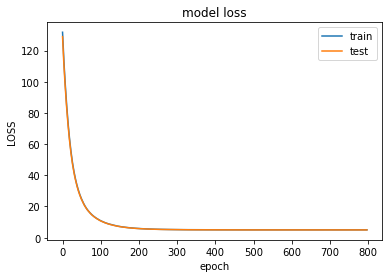

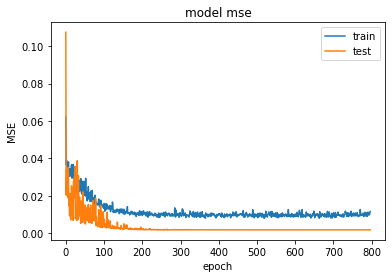

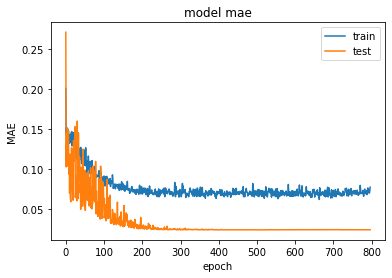

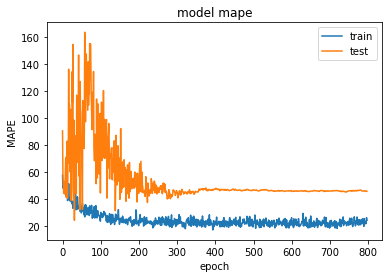

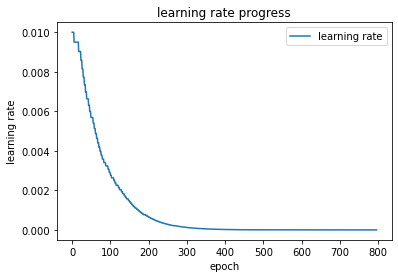

Exception in thread Thread-8:
Traceback (most recent call last):
  File "C:\Users\kenneth\Anaconda3\envs\tf115\lib\site-packages\urllib3\connection.py", line 160, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw
  File "C:\Users\kenneth\Anaconda3\envs\tf115\lib\site-packages\urllib3\util\connection.py", line 61, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "C:\Users\kenneth\Anaconda3\envs\tf115\lib\socket.py", line 752, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\kenneth\Anaconda3\envs\tf115\lib\site-packages\urllib3\connectionpool.py", line 677, in urlopen
    chunked=chunked,
  File "C:\Users\kenneth\Anaconda3\envs\tf115\lib\site-packages\urllib3\connectionpool.py", line 381, in _make_reque

In [ ]:
if best_model_search:
    if __name__ == '__main__':
       
        best_run, best_model = optim.minimize(model=create_cudnnlstm_model, data=data,functions = [data_split, data_params, feature_selection],algo=tpe.suggest,
                                              max_evals=max_evals,trials=Trials(), notebook_name=model_name,rseed=random_state, eval_space=True, verbose=False)
        
               
        
        print("Evaluation of best performing model:")
        build_path('best_model')
        best_model.save('best_model/'+model_name+'.h5')
        print('\n'+'*'*20+"Best Model Configuration:"+'*'*20)
        print(best_model.get_config())
        f = open('best_model/'+model_name+'_best_run.pickle', 'wb')# save best_run parameters in a pickle file
        pickle.dump(best_run, f)
        f.close()
        
        kfold, train_size, shuffle, split, fold_number,random_state = data_split()
        batch_size, time_steps, rm_window, hyperas_epochs, forecast_period, x_scaler, y_scaler = data_params()           
        x_train, y_train, x_test, y_test, batch_size, time_steps, x_predict, last_date, ticker, x_scaler, y_scaler = data()

        val_loss, val_mse, val_mae, val_mape = best_model.evaluate(x_test, y_test, batch_size=batch_size)
        print('val_loss: ', val_loss, ' val_mse: ',val_mse, ' val_mae: ',val_mae,  ' val_mape: ',val_mape)
        print('\n'+'*'*20+"Best Run hyper-parameters:"+'*'*20)
        print(best_run)
        del best_model, best_run, x_train, x_test, y_train, y_test, x_predict
        gc.collect()
        

if  perform_training:
    kfold, train_size, shuffle, split, fold_number,random_state = data_split()
    batch_size, time_steps, rm_window, hyperas_epochs, forecast_period, x_scaler, y_scaler = data_params()           
    x_train, y_train, x_test, y_test, batch_size, time_steps, x_predict, last_date, ticker, x_scaler, y_scaler = data()
    training()
    del x_train, x_test, y_train, y_test, x_predict
   

In [ ]:
if not os.path.exists('train_model/'+model_name+'.h5'):
    print('Trained model doesnt exist, changing evaluate_all_folds to False')
    evaluate_all_folds = False
if evaluate_all_folds:
    kfold, train_size, shuffle, split, fold_number,random_state = data_split()
    batch_size, time_steps, rm_window, hyperas_epochs, forecast_period, x_scaler,y_scaler = data_params()
    df, y, ticker = feature_selection()
    model = load_model('train_model/'+model_name+'.h5')
    print('loaded trained model')
    
    # add percent change
    #df=df.pct_change()
    #df=df.replace([np.inf, -np.inf],np.nan) 
    #df.fillna(0, inplace=True)
    #df.isnull().any().mean()
    y=y.shift(-forecast_period)
    
    # apply preprocessing 
    x = x_scaler.fit_transform(df)
    y = y_scaler.fit_transform(y)
    del df
    gc.collect()
    

    # apply time steps
    def create_dataset(X, y, time_steps=1):
        Xs, ys = [], []
        for i in range(len(X) - time_steps):
            v = X[i:(i + time_steps)]
            Xs.append(v)
            ys.append(y[i + time_steps])
        return np.array(Xs), np.array(ys)
    x, y = create_dataset(x, y, time_steps)
    # forecast periods and removing last7 rows (for the target being NaN for 7 day model)
    x = x[:-forecast_period]
    y =  y[:-forecast_period]

    #implementation of fold
    print('started Kfold')

    count = 0
    fd = KFold(n_splits=split, random_state=random_state, shuffle=shuffle)

    for train_index, test_index in fd.split(x):
        count +=1
        print('processing fold number ', count)

        _, x_test,_, y_test  = x[train_index], x[test_index], y[train_index], y[test_index]
        x_test = x_test.astype('float32')
        y_test = y_test.astype('float32')
    
        # adjustment for batch_size
        test_start = x_test.shape[0]%batch_size
        x_test = x_test[test_start:]
        y_test = y_test[test_start:]
        val_loss, val_mse, val_mae, val_mape = model.evaluate(x_test, y_test, batch_size=batch_size)
        print('Fold Number ', count,'val_loss: ', val_loss, ' val_mse: ',val_mse, '\n',' val_mae: ',val_mae,  ' val_mape: ',val_mape)
        del x_test, y_test
       